In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import re
import warnings
import random
import matplotlib
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from scipy.stats import linregress, spearmanr
import analysis_utils
from copy import deepcopy
import importlib

# path to repository folder (data is stored here as well)
path = '..'
preds_loc = os.path.join(path, 'data', 'Ssym_mapped_preds_clusters.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

In [2]:
ssymp = pd.read_csv(os.path.join(path, 'data', 'Ssym+_experimental.csv'))
ssymp['uid'] = ssymp['Protein'].str[:4].apply(lambda x: x.upper())  + '_' + ssymp['Mut_pdb'].str[1:]
ssymp = ssymp.set_index('uid')

In [3]:
### load and preprocess data

# load main data
db = pd.read_csv(preds_loc, index_col=0)

db = db.reset_index()
db['uid2'] = db['code'] + '_' + db['position'].astype(int).astype(str) + db['mutation'].str[-1]
db = db.set_index(['uid', 'uid2'])

for code in db['wt_code'].unique():
    cluster = db.loc[db['code']==code, 'cluster'].head(1).item()
    db.loc[db['wt_code']==code, 'cluster'] = cluster

db['direction'] = 'dir'
db.loc[db['code']!=db['wt_code'], 'direction'] = 'inv'

for col in ['KORPM', 'Cartddg', 'FoldX', 'Evo', 'Dyna2', 'PopMs', 'DDGun', 'TNet', 'ACDCNN', 'ddG']:
    db = db.rename({col: col + '_dir'}, axis=1)

# extract prediction columns
incl = [col for col in db.columns if '_dir' in col and not 'runtime' in col]
# get only unique mutations (predictions are always the same)
db_preds = db[incl].drop_duplicates()
#print(db_preds.head())
#db_ddg = db[['ddG_dir']]
db_clusters = db[['cluster']]
db_direction = db[['direction']]
db_ddgs = db[['ddG_dir']]

# extract runtimes for each prediction type
db_runtimes = db[[col for col in db.columns if 'runtime' in col] + ['code']].drop_duplicates()
# estimate the per-mutation runtime (the code takes about 6 seconds to run 6313 mutations)
db_runtimes['runtime_korpm_dir'] = 0.0015

# reassign the Tranception runtimes to be per-mutation (by dividing by the number of mutations)
for col in [c for c in db_runtimes.columns if 'tranception' in c]:
    grouped = db_runtimes.groupby('code')[col]
    mean_values = grouped.mean()
    group_sizes = grouped.size()

    # Divide mean values by group sizes
    divided_values = mean_values / group_sizes
    # Merge the divided_values back to the original DataFrame
    db_runtimes = db_runtimes.merge(divided_values.rename('divided_value'), left_on='code', right_index=True)
    # Reassign the 'target_column' values with the divided values
    db_runtimes[col] = db_runtimes['divided_value']
    # Drop the 'divided_value' column
    db_runtimes = db_runtimes.drop('divided_value', axis=1)

# ~15 seconds

In [4]:
original_pred_cols = [c for c in db.columns if '_dir' in c and not 'runtime' in c and not 'pll' in c and not 'ddG' in c]
db_preds = db[original_pred_cols]

original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
#for col in ['esm2_15B_half_dir', 'esm2_150M_dir']:
#    original_pred_cols_reduced.remove(col)

db_preds

,,esmif_monomer_dir,ACDCNN_dir,Cartddg_dir,DDGun_dir,Dyna2_dir,Evo_dir,FoldX_dir,KORPM_dir,PopMs_dir,TNet_dir,...,esm1v_2_dir,esm1v_3_dir,esm1v_4_dir,esm1v_5_dir,esm1v_median_dir,esm1v_mean_dir,ankh_dir,korpm_dir,mutcomputex_dir,stability-oracle_dir
uid,uid2,,,,,,,,,,,,,,,,,,,,,
107L_44S,107L_44S,0.016577,-0.131,1.69,0.072,-0.581,0.70,0.57,0.427,0.13,0.01,...,0.800201,0.605376,0.510154,1.220110,0.605376,0.642675,4.276441,0.544,-0.999986,0.438
108L_44S,108L_44S,-0.009064,-0.334,-1.73,-0.106,-0.295,-1.46,-0.47,0.159,0.39,-0.40,...,0.492721,0.396152,0.220262,0.268132,0.268132,0.240539,1.753344,0.194,-0.034210,-0.105
109L_44S,109L_44S,-0.005914,-0.175,-0.98,0.009,-0.340,0.06,-0.62,-0.051,-0.26,-0.01,...,-0.860153,0.054036,-0.641212,-0.931148,-0.641212,-0.566803,2.483467,-0.079,-0.406980,-0.375
110L_44S,110L_44S,0.005226,-0.157,-1.26,-0.099,-0.213,-1.34,-0.65,0.087,0.21,-0.40,...,0.503650,0.549975,0.508147,0.413473,0.503650,0.466007,2.295459,0.108,-0.089660,-0.103
111L_44S,111L_44S,0.003130,-0.028,-0.24,0.000,0.218,-0.15,-0.61,0.127,-0.02,-0.09,...,0.433894,0.670423,0.394354,0.552454,0.433894,0.483406,2.562860,0.170,0.012168,0.197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5PTI_23A,5PTI_23A,-0.199087,-3.108,-8.00,-3.658,-3.856,-3.57,-1.42,-2.601,-1.03,-2.63,...,-8.460078,-8.768191,-8.526881,-8.345311,-8.460078,-8.293155,-11.227180,-3.278,-0.861620,-2.782
5PTI_35G,5PTI_35G,-0.296928,-3.816,-8.00,-3.980,-3.944,-4.04,-3.03,-2.470,0.22,-1.77,...,-7.625252,-7.928805,-9.172729,-7.315306,-7.928805,-8.104215,-8.834322,-3.128,-0.531967,-3.854
5PTI_43G,5PTI_43G,-0.301580,-1.786,-8.00,-1.756,-3.047,-3.00,-2.02,-1.219,-0.15,-0.58,...,-6.248067,-6.697584,-5.424959,-8.513042,-6.697584,-6.862028,-8.326775,-1.552,-0.957911,-1.180


In [5]:
df_cart, df_cart_runtimes = analysis_utils.parse_rosetta_predictions(db.reset_index('uid', drop=True).reset_index().rename({'uid2': 'uid'}, axis=1).set_index('uid'), os.path.join(path, 'data', 'rosetta_predictions'), runtime=True)
db_preds = db_preds.reset_index().rename({'uid': 'uid_', 'uid2': 'uid'}, axis=1).set_index('uid').join(df_cart.astype(float).rename_axis('uid'), how='left')
db_preds = db_preds.reset_index(drop=True).rename({'uid_': 'uid'}, axis=1).set_index('uid')
db_runtimes = db_runtimes.reset_index('uid').join(df_cart_runtimes.astype(float), how='left')

In [6]:
#db_complete = db.copy(deep=True)
#db_complete = pd.read_csv(preds_loc, index_col=0)

# load effective number of sequences from separate file (generated by MSA transformer)
neff = pd.read_csv(os.path.join(path, 'data', 'neff_ssym.csv'), header=None).set_index(0)
neff.index.name = 'code'
neff.columns = ['neff', 'sequence_length']
neff = neff.groupby(level=0).max()

db_feats_2 = pd.read_csv(os.path.join(path, 'data', 'Ssym_local_mapped_feats.csv'))
db_feats_2['uid'] = db_feats_2['code'] + '_' + db_feats_2['position_orig'].astype(str) + db_feats_2['mutation']
db_feats_2['uid2'] = db_feats_2['code'] + '_' + db_feats_2['position'].astype(str) + db_feats_2['mutation']

db_feats_2 = db_feats_2.set_index('uid')
db_feats_2 = db_feats_2[['uid2', 'on_interface', 'entropy', 'conservation', 'column_completeness', 'completeness_score', 'n_seqs', 'structure_length', 'SS', 'position_orig',
                        'features', 'hbonds', 'saltbrs', 'b_factor', 'kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'rel_ASA', 'wt_code', 'code', 'position', 'wild_type', 'mutation']] #'residue_depth',

db_feats_2['on_interface'] = db_feats_2['on_interface'].astype(int)
db_feats_2['features'] = db_feats_2['features'].fillna("")#.apply(list)
#db_complete = db_complete.join(db_feats_2.set_index('uid'))#.drop('uid2', axis=1).set_index('uid')
db_feats_2['delta_kdh'] = db_feats_2['kdh_mut'] - db_feats_2['kdh_wt']
db_feats_2['delta_vol'] = db_feats_2['vol_mut'] - db_feats_2['vol_wt']
db_feats_2['delta_chg'] = db_feats_2['chg_mut'] - db_feats_2['chg_wt']
#db_feats_2['delta_asa'] = db_feats_2['SOL_ACC_inv'] - db_feats_2['SOL_ACC_dir']
db_feats_2['to_proline'] = (db_feats_2.index.str[-1] == 'P').astype(int)
db_feats_2['to_glycine'] = (db_feats_2.index.str[-1] == 'G').astype(int)
db_feats_2['from_proline'] = (db_feats_2.index.str[6] == 'P').astype(int)
db_feats_2['from_glycine'] = (db_feats_2.index.str[6] == 'G').astype(int)
db_feats_2['helix'] = db_feats_2['SS'] == 'H'
db_feats_2['bend'] = db_feats_2['SS'] == 'S'
db_feats_2['turn'] = db_feats_2['SS'] == 'T'
db_feats_2['coil'] = db_feats_2['SS'] == '-'
db_feats_2['strand'] = db_feats_2['SS'] == 'E'
#db_feats_2['xray_else_NMR'] = db_feats_2['nmr_xray'].str.contains('X-RAY')
db_feats_2['active_site'] = db_feats_2['features'].str.contains('ACT_SITE')
#db_feats_2['resolution'] = db_feats_2['resolution'].fillna('').apply(lambda x: analysis_utils.extract_decimal_number(x))
#db_feats_2['mpnn_median_dir'] = db_feats_2[['mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir']].mean(axis=1)
db_feats_2 = db_feats_2.drop(['kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'features', 'SS'], axis=1)
# 'mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir', 'mpnn_10_dir', 'mpnn_30_dir', 'mpnn_30_03_dir', 'mpnn_20_02_dir',
db_feats_2 = db_feats_2.reset_index().merge(neff['neff'].dropna(), on='code', how='left')#.drop('code', axis=1)#.set_index('uid')
db_feats_2['neff'] = db_feats_2['neff'].fillna(0)
unique_indices = db_feats_2.groupby('uid')['neff'].idxmax()#.astype(int)
db_feats_2 = db_feats_2.loc[unique_indices].set_index(['uid', 'uid2'])

#db_complete['random_dir'] = np.random.rand(len(db_complete)) - 0.5

for feature in ['on_interface', 'features', 'rel_ASA', 'delta_kdh', 'delta_vol', 'delta_chg', 'to_proline', 'to_glycine', 'from_proline', 'from_glycine', 'helix', 'bend', 'turn', 'coil', 'strand', 'active_site']:
    db_feats_2 = db_feats_2.rename({feature: feature + '_dir'}, axis=1)

db_feats_2

,,on_interface_dir,entropy,conservation,column_completeness,completeness_score,n_seqs,structure_length,position_orig,hbonds,saltbrs,...,to_glycine_dir,from_proline_dir,from_glycine_dir,helix_dir,bend_dir,turn_dir,coil_dir,strand_dir,active_site_dir,neff
uid,uid2,,,,,,,,,,,,,,,,,,,,,
107L_44S,107L_44S,0,1.350482,4.048295,0.308949,0.850995,1408.0,162,44,2,0,...,0,0,0,True,False,False,False,False,False,0.000000
108L_44S,108L_44S,0,1.350482,0.355114,0.308949,0.850995,1408.0,162,44,2,0,...,0,0,0,True,False,False,False,False,False,0.000000
109L_44S,109L_44S,0,1.350482,3.764205,0.308949,0.850995,1408.0,162,44,2,0,...,0,0,0,True,False,False,False,False,False,0.000000
110L_44S,110L_44S,0,1.350482,0.994318,0.308949,0.850995,1408.0,162,44,2,0,...,0,0,0,True,False,False,False,False,False,0.000000
111L_44S,111L_44S,0,1.350482,5.113636,0.308949,0.850995,1408.0,162,44,2,0,...,0,0,0,True,False,False,False,False,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5PTI_23A,5PTI_23A,0,0.778851,63.758389,0.999484,0.823609,1937.0,58,23,2,0,...,0,0,0,False,False,False,False,True,False,1516.376889
5PTI_35G,5PTI_35G,0,1.059996,74.909654,0.993289,0.823609,1937.0,58,35,2,0,...,1,0,0,False,False,False,False,True,False,1516.376889
5PTI_43G,5PTI_43G,0,0.222989,96.644295,0.999484,0.823609,1937.0,58,43,4,0,...,1,0,0,False,True,False,False,False,False,1516.376889


In [7]:
df = db_preds.join(db_feats_2[['delta_kdh_dir', 'delta_vol_dir', 'rel_ASA_dir', 'wt_code', 'wild_type', 'position_orig', 'mutation']]).join(db_ddgs).join(db_runtimes).reset_index('uid2')

df['code'] = df.index.str[:4]
db1 = df.loc[df['code'].str[:4]==df['wt_code']]
print(len(db1))
db1 = db1.drop(['code', 'wt_code'], axis=1)
#db1.columns = [c + '_dir' for c in db1.columns]
db2 = df.loc[df['code'].str[:4]!=df['wt_code']]
db2['uid'] = db2['wt_code'] + '_' + db2['position_orig'].astype(str) + db2['wild_type']
db2 = db2.set_index('uid')
print(len(db2))
db2 = db2.drop(['code', 'wt_code'], axis=1)
db2.columns = [c.replace('_dir', '_inv') for c in db2.columns]
db2 = db2[[c for c in db2.columns if '_inv' in c]]
db_flat = db1.join(db2)
db_flat

# sequence methods are necessarily antisymmetric. This fills in missing or erroneous values
for col in db_flat.columns:
    if '_dir' in col:
        if any([e in col for e in ['esm2', 'esm1v', 'msa', 'tranception', 'ankh']]) and not 'runtime' in col:
            db_flat[col.replace('_dir', '_inv')] = -db_flat[col]

db_ddgs_2 = db_flat[['ddG_dir', 'ddG_inv']]
db_flat

test = db_flat.join(ssymp, lsuffix='_plus').drop('uid2', axis=1)
float_columns = test.select_dtypes(include=['float']).columns
db_class = test[float_columns]
db_class.columns = ['plus_' + c[:-5] if 'plus' in c else c for c in db_class.columns]
db_class = db_class.drop([c+'_dir' for c in ['ACDCNN', 'ACDC-NN-2str', 'plus_FoldX', 'plus_DDGun', 'PopMs', 'TNet', 'Dyna2']], axis=1)
db_class = db_class.drop([c+'_inv' for c in ['ACDCNN', 'ACDC-NN-2str', 'plus_FoldX', 'plus_DDGun', 'PopMs', 'TNet', 'Dyna2']], axis=1)

db_stacked = analysis_utils.stack_frames(db_class)
db_stacked_preds = db_stacked[[c for c in db_stacked.columns if not 'runtime' in c]]
db_stacked_runtimes = db_stacked[[c for c in db_stacked.columns if 'runtime' in c]]
db_stacked_runtimes

342
342


pred_col             runtime_ankh  runtime_cartesian_ddg  runtime_esm1v_1  \
direction uid                                                               
dir       1AMQ_191F      0.182606                    6.0         0.067344   
          1AMQ_191S      0.181212                    8.0         0.066351   
          1AMQ_191W      0.180855                    8.0         0.066890   
          1AMQ_191Y      0.180631                    7.0         0.067232   
          1BNI_14A       0.107334                    6.0         0.034200   
...                           ...                    ...              ...   
inv       5PTI_22A       0.112357                    5.0         0.030202   
          5PTI_23A       0.106133                    7.0         0.030067   
          5PTI_35G       0.105802                   11.0         0.030636   
          5PTI_43G       0.105657                   11.0         0.030900   
          5PTI_45A       0.095485                   66.0         0.032464   

pred_col             runtime_esm1v_2  runtime_esm1v_3  runtime_esm1v_4  \
direction uid                                                            
dir       1AMQ_191F         0.066230         0.066228         0.066444   
          1AMQ_191S         0.066204         0.066053         0.066372   
          1AMQ_191W         0.066931         0.066286         0.071942   
          1AMQ_191Y         0.066729         0.066720         0.066427   
          1BNI_14A          0.031118         0.030738         0.030340   
...                              ...              ...              ...   
inv       5PTI_22A          0.028447         0.029896         0.029325   
          5PTI_23A          0.028884         0.030771         0.032039   
          5PTI_35G          0.031073         0.030899         0.031054   
          5PTI_43G          0.028669         0.031164         0.030806   
          5PTI_45A          0.027214         0.030750         0.029823   

pred_col             runtime_esm1v_5  runtime_esm1v_mean  \
direction uid                                              
dir       1AMQ_191F         0.065980            0.332226   
          1AMQ_191S         0.066340            0.331320   
          1AMQ_191W         0.066381            0.338431   
          1AMQ_191Y         0.066803            0.333911   
          1BNI_14A          0.031391            0.157787   
...                              ...                 ...   
inv       5PTI_22A          0.031306            0.149177   
          5PTI_23A          0.030846            0.152607   
          5PTI_35G          0.029357            0.153019   
          5PTI_43G          0.030116            0.151654   
          5PTI_45A          0.026830            0.147081   

pred_col             runtime_esm1v_median  runtime_esm2  ...  \
direction uid                                            ...   
dir       1AMQ_191F              0.332226      0.185272  ...   
          1AMQ_191S              0.331320      0.184729  ...   
          1AMQ_191W              0.338431      0.184060  ...   
          1AMQ_191Y              0.333911      0.184031  ...   
          1BNI_14A               0.157787      0.070894  ...   
...                                   ...           ...  ...   
inv       5PTI_22A               0.149177      0.060836  ...   
          5PTI_23A               0.152607      0.061388  ...   
          5PTI_35G               0.153019      0.060102  ...   
          5PTI_43G               0.151654      0.060871  ...   
          5PTI_45A               0.147081      0.060835  ...   

pred_col             runtime_mpnn_20_00  runtime_mpnn_30_00  runtime_msa_1  \
direction uid                                                                
dir       1AMQ_191F            0.016232            0.016989       3.390493   
          1AMQ_191S            0.014761            0.016065       3.393482   
          1AMQ_191W            0.014751            0.016062       3.393750   
          1AMQ_191Y            

Original unique mutations: 684
['ACDC-NN', 'ACDC-NN-Seq', 'Cartddg', 'DDG', 'DDGun', 'DDGun3D', 'DUET', 'Dynamut', 'Dynamut2', 'Evo', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq', 'INPS-Seq', 'INPS3D', 'KORPM', 'MAESTRO', 'MUpro', 'PoPMuSiC', 'PremPS', 'SAAFEC-SEQ', 'SDM', 'ThermoNet', 'ankh', 'cartesian_ddg', 'delta_kdh', 'delta_vol', 'esm1v_mean', 'esm1v_median', 'esm2', 'esm2_150M', 'esm2_15B_half', 'esm2_650M', 'esmif_monomer', 'esmif_multimer', 'korpm', 'mCSM', 'mif', 'mifst', 'mpnn_10_00', 'mpnn_20_00', 'mpnn_30_00', 'msa_transformer_mean', 'msa_transformer_median', 'mutcomputex', 'rel_ASA', 'stability-oracle', 'tranception']
direction  uid      
dir        1AMQ_191F     9
inv        1AMQ_191F     9
dir        1AMQ_191S     9
inv        1AMQ_191S     9
dir        1AMQ_191W     9
                        ..
inv        5PTI_35G     10
dir        5PTI_43G     10
inv        5PTI_43G     10
dir        5PTI_45A     10
inv        5PTI_45A     10
Name: cluster, Length: 684, dtype: int64
clus

,,ACDC-NN,ACDC-NN-Seq,Cartddg,DDG,DDGun,DDGun3D,DUET,Dynamut,Dynamut2,Evo,...,evolutionary,supervised,potential,biophysical,mpnn_rosetta,mpnn_mean,esmif_mean,mif_mean,esm2_mean,random
direction,uid,,,,,,,,,,,,,,,,,,,,,
dir,1AMQ_191F,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,-1.34,-0.43,...,-1.776021,-0.711539,-1.3885,-2.812697,-9.940203,-4.778174,-0.015589,-12.458407,-10.560310,-0.121645
inv,1AMQ_191F,-0.179437,0.000000,-2.74,1.6,-1.0,-1.0,-1.735,-0.727,-2.07,-0.16,...,1.776021,-0.880870,0.1840,-2.659794,-1.550977,4.457189,0.001454,7.670020,10.560310,-0.247899
dir,1AMQ_191S,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,-2.18,-1.18,...,-1.003277,-0.952740,-1.8350,-1.306891,-5.129149,-1.181782,-0.001735,-5.418851,-7.020352,-0.917690
inv,1AMQ_191S,0.150363,0.000000,2.98,1.9,-0.2,0.4,-0.375,1.315,-1.60,0.92,...,1.003277,-0.257260,0.9130,0.588854,2.337425,0.500737,0.002832,5.115492,7.020352,0.533836
dir,1AMQ_191W,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,-1.75,0.24,...,-2.152466,-0.751665,-1.7220,-7.286984,-21.056967,-4.886387,-0.019595,-15.447867,-12.515907,1.015241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
inv,5PTI_35G,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,-0.55,0.81,...,1.478953,0.706363,-1.5615,-0.202346,-4.590325,-5.502252,-0.287358,-5.079619,7.949675,1.916245
dir,5PTI_43G,-1.785572,-1.548846,-8.00,-5.7,-2.1,-1.9,-2.580,-1.420,-3.05,-3.00,...,-1.301072,-1.673863,-1.0945,-6.599450,-20.197576,-5.652171,-0.301580,-12.463080,-7.696587,1.097824
inv,5PTI_43G,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,-0.56,1.96,...,1.301072,0.042591,0.2480,3.659356,15.060090,4.868737,0.049030,8.559274,7.696587,1.937968


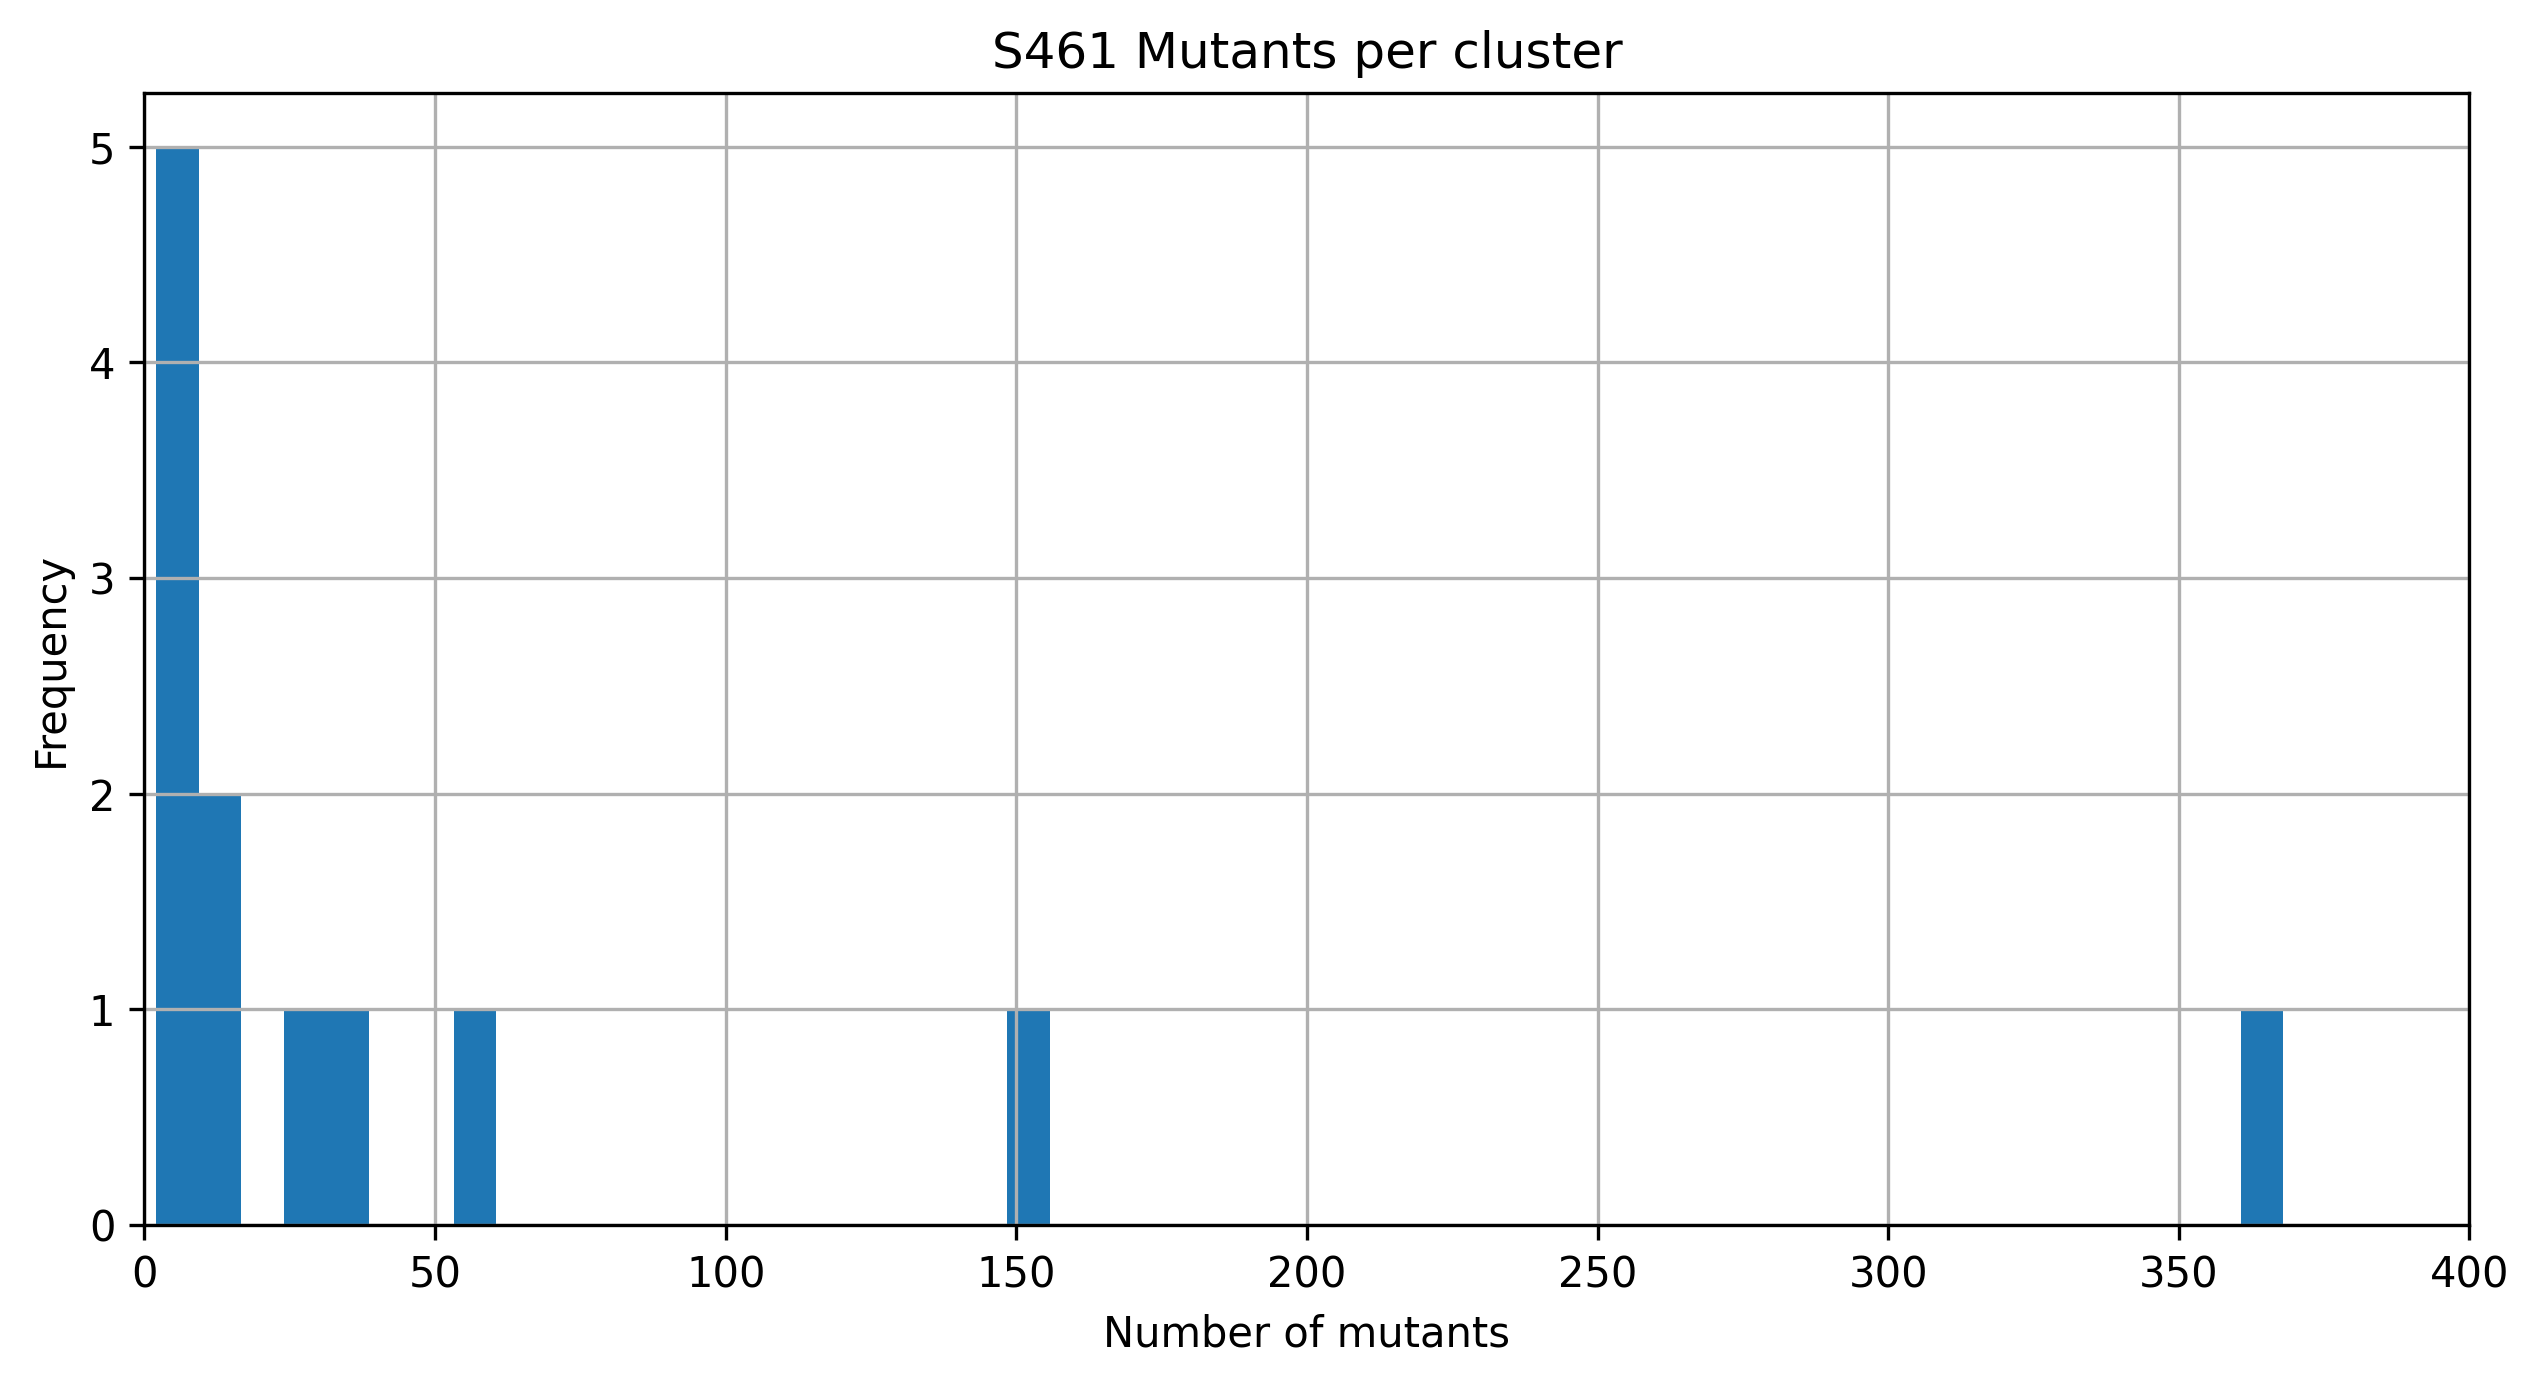

In [42]:
# compile predictions and measurements for statistical analysis
db_class = db_stacked_preds.reset_index().set_index('uid').join(db_ddgs_2).join(db_clusters.reset_index('uid2', drop=True)).reset_index().set_index(['direction', 'uid'])
print('Original unique mutations:', len(db_class))

original_pred_cols = [c for c in db_class.columns if  not 'runtime' in c and not 'pll' in c and not 'ddG' in c and not 'cluster' in c]
original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
#for col in ['esm2_15B_half_dir', 'esm2_150M_dir']:
#    original_pred_cols_reduced.remove(col)
print(original_pred_cols_reduced)

db_class = db_class[original_pred_cols_reduced + ['ddG', 'cluster']]

evolutionary = ['tranception', 'msa_transformer', 'esm1v', 'msa', 'esm2', 'ankh']
structural = ['mpnn', 'mif', 'mifst', 'esmif']
supervised = ['MAESTRO', 'ThermoNet', 'INPS', 'PremPS', 'mCSM', 'DUET', 'ACDC', 'I-Mutant3.0', 'SAAFEC', 'MuPro']
untrained = ['DDGun']
potential = ['KORPM', 'PopMusic', 'SDM']
biophysical = ['cartesian_ddg', 'FoldX', 'Evo']

db_class_rescaled = db_class.copy(deep=True)
db_class_rescaled[original_pred_cols_reduced] /= db_class_rescaled[original_pred_cols_reduced].std()

db_class['structural'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in structural])]].mean(axis=1)
db_class['evolutionary'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in evolutionary])]].mean(axis=1)
db_class['supervised'] = db_class[[c for c in db_class.columns if any([s in c for s in supervised])]].mean(axis=1)
db_class['potential'] = db_class[[c for c in db_class.columns if any([s in c for s in potential])]].mean(axis=1)
db_class['biophysical'] = db_class[[c for c in db_class.columns if any([s in c for s in biophysical])]].mean(axis=1)
db_class['mpnn_rosetta'] = db_class['cartesian_ddg'] + db_class['mpnn_20_00']

db_class['mpnn_mean'] = db_class[['mpnn_10_00', 'mpnn_20_00', 'mpnn_30_00']].mean(axis=1)
#db_runtimes['runtime_mpnn_mean'] = db_runtimes[['runtime_mpnn_10_00', 'runtime_mpnn_20_00', 'runtime_mpnn_30_00']].sum(axis=1)

db_class['esmif_mean'] = db_class[['esmif_multimer', 'esmif_monomer']].mean(axis=1)
#db_runtimes['runtime_esmif_mean'] = db_runtimes[['runtime_esmif_multimer', 'runtime_esmif_monomer']].sum(axis=1)

db_class['mif_mean'] = db_class[['mif', 'mifst']].mean(axis=1)
#db_runtimes['runtime_mif_mean'] = db_runtimes[['runtime_mif', 'runtime_mifst']].sum(axis=1)

db_class['esm2_mean'] = db_class[['esm2_15B_half', 'esm2', 'esm2_650M', 'esm2_150M']].mean(axis=1)
#db_runtimes['runtime_esm2_mean'] = db_runtimes[['runtime_esm2_15B_half', 'runtime_esm2', 'runtime_esm2_650M', 'runtime_esm2_150M']].sum(axis=1)

#db_class['ensemble_dir'] = db_class['cartesian_ddg_dir'] + db_class['mpnn_20_00_dir']
# random (Gaussian noise) control
db_class['random'] = np.random.normal(loc=0, size=len(db_class))
db_class['korpm'] = db_class['KORPM']

#db_class = db_class.reset_index('uid2', drop=True)

print(db_class['cluster'])

fig, axes = plt.subplots(1, figsize=(10, 5), dpi=300) 
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=50, ax=axes)
#db_class.groupby('cluster').count().iloc[:, 0].hist(bins=800, ax=axes[1])
plt.xlim([0,400])
plt.title('S461 Mutants per cluster')
plt.xlabel('Number of mutants')
plt.ylabel('Frequency')

group_counts = db_class.groupby('cluster').count().iloc[:, 0]
print(group_counts)
large_groups = group_counts > 0
filtered_df = db_class[db_class['cluster'].isin(large_groups[large_groups].index)]
db_class = filtered_df

#l1 = len(db_class)
#db_class = db_class.loc[~db_feats_2['on_interface']]
#l2 = len(db_class)
#print(f'Dropped {l1-l2} interface mutations')
#db_class = db_class.loc[~db_feats_2['on_interface']]
#print(f'Dropped {l2-len(db_class)} mutations in binding regions')

print('Unique mutations in chosen set:', len(db_class))
print('Unique clusters (protein families with significant structural homology):', len(db_class['cluster'].unique()))

#db_class = db_class.T.drop_duplicates().T
db_class.to_csv('../data/Ssym_mapped_preds_clusters_extra.csv')
db_class

In [41]:
db_class.groupby('cluster').count().iloc[:, [1]]

,ACDC-NN-Seq
cluster,
1,368
2,28
3,6
4,4
5,2
6,6
7,10
8,150
9,8


In [9]:
db_class = pd.read_csv('../data/Ssym_mapped_preds_clusters_extra.csv')
db_class = db_class.set_index(['direction', 'uid'])
#db_class = db_class.drop_duplicates()
#db_class.columns = [c[:-4] for c in db_class.columns]
#db_class = db_class.reset_index().set_index(['direction', 'uid'])
db_class


,,ACDC-NN,ACDC-NN-Seq,Cartddg,DDG,DDGun,DDGun3D,DUET,Dynamut,Dynamut2,Evo,...,evolutionary,supervised,potential,biophysical,mpnn_rosetta,mpnn_mean,esmif_mean,mif_mean,esm2_mean,random
direction,uid,,,,,,,,,,,,,,,,,,,,,
dir,1AMQ_191F,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,-1.34,-0.43,...,-1.776021,-0.711539,-1.3885,-2.812697,-9.940203,-4.778174,-0.015589,-12.458407,-10.560310,-1.145936
inv,1AMQ_191F,-0.179437,0.000000,-2.74,1.6,-1.0,-1.0,-1.735,-0.727,-2.07,-0.16,...,1.776021,-0.880870,0.1840,-2.659794,-1.550977,4.457189,0.001454,7.670020,10.560310,-0.315230
dir,1AMQ_191S,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,-2.18,-1.18,...,-1.003277,-0.952740,-1.8350,-1.306891,-5.129149,-1.181782,-0.001735,-5.418851,-7.020352,1.837946
inv,1AMQ_191S,0.150363,0.000000,2.98,1.9,-0.2,0.4,-0.375,1.315,-1.60,0.92,...,1.003277,-0.257260,0.9130,0.588854,2.337425,0.500737,0.002832,5.115492,7.020352,0.148978
dir,1AMQ_191W,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,-1.75,0.24,...,-2.152466,-0.751665,-1.7220,-7.286984,-21.056967,-4.886387,-0.019595,-15.447867,-12.515907,-1.678626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
inv,5PTI_35G,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,-0.55,0.81,...,1.478953,0.706363,-1.5615,-0.202346,-4.590325,-5.502252,-0.287358,-5.079619,7.949675,-0.563550
dir,5PTI_43G,-1.785572,-1.548846,-8.00,-5.7,-2.1,-1.9,-2.580,-1.420,-3.05,-3.00,...,-1.301072,-1.673863,-1.0945,-6.599450,-20.197576,-5.652171,-0.301580,-12.463080,-7.696587,-0.781370
inv,5PTI_43G,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,-0.56,1.96,...,1.301072,0.042591,0.2480,3.659356,15.060090,4.868737,0.049030,8.559274,7.696587,1.587247


In [10]:
#db_complete = pd.read_csv(preds_loc.replace('_clusters', '_clusters_extra')).set_index('uid')
#df = db_class.copy(deep=True)#preds.copy(deep=True).join(db_ddgs)
#df_ = df[[c for c in df.columns if '_dir' in c]]
#df_.columns = [c[:-4] for c in df_.columns]
#df_ = df_.join(db_direction).join(db_clusters)
#df_ = df_.reset_index().set_index(['direction', 'uid'])
#df_['ens'] = df_['cartesian_ddg'] + df_['mpnn_20_00']
#df_['ens2'] = df_['ACDCNN'] + df_['mpnn_20_00']
#df_ = df_.drop('uid2', axis=1)

In [11]:
importlib.reload(analysis_utils)
# compute statistics on the results for use by later methods
class_result = analysis_utils.compute_stats_bidirectional(db_class, stats=(), grouper='cluster', stacked=True)
#class_result.to_csv(os.path.join(path, 'results', 's461_summary_table.csv'))

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [12]:
table1 = class_result #.loc[:,['n', 'MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman']]
table = table1.sort_values(['direction', 'weighted_spearman'], ascending=False).reset_index()

for source, target in remap_names.items():
    table.loc[table['model']==source, 'model'] = target
#table['model'] = table['model'].map(remap_names)
table.loc[table['model'].isin(['Gaussian noise', 'ΔΔG', 'ΔTm']), 'model_type'] = 'N/A'

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'antisymmetry': 'Antisymmetry', 'bias': 'Bias',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'pearson': 'Pearson', 'precision': 'Precision'}
table = table.rename(remap_cols, axis=1)
#table = table[['direction', 'model_type', 'model', 'n', 'MCC', 'AUPRC', 'ρ', 'wNDCG', 'wAUPRC', 'wρ', 'mean_t1s', 'Net Stabilization',
#    'mean_stabilization', 'mean PPC', 'mean MSC', 'True Positives', 'Sensitivity', 'Accuracy', 'Pearson']]
table = table.rename({'direction': 'Direction', 'model_type': 'Model Type', 'model': 'Model'}, axis=1)
table = table[['Direction', 'Model Type', 'Model', 'n', 'Spearman\'s ρ', 'Sensitivity', 'Precision', 'Antisymmetry', 'Bias']]
#table = table.loc[table['model'].isin(['PremPS'])] 
#table = table.loc[table['Model'].isin(['Rosetta CartDDG', 'ProteinMPNN mean', 'ProteinMPNN 30', 'ProteinMPNN 20', 'ESM-IF', 'MIF', 'ESM-IF(M)', 'Ankh', 'MutComputeX',
#    'ESM-2 3B', 'ESM-2 15B', 'ESM-2 150M', 'ESM-2 650M', #'ESM-2 mean', 'ESM-IF mean', 'MIF mean', 'Clustered Ensemble', 'Ensemble 2', 'ESM-1V 2', 'MSA-T 1', 'Structural', 'Evolutionary', 'Supervised'
#    'ProteinMPNN 10', 'MIF-ST', 'KORPM', 'MSA-T mean', 'Tranception', 'ESM-1V mean', 'Stability Oracle', 'Ankh', 'MAESTRO', 'ThermoNet', 'ACDC-NN', 'ACDC-NN-Seq', 'PremPS',
#    'PoPMuSiC', 'SDM', 'FoldX', 'Evo', 'INPS3D', 'INPS-Seq', 'DDGun', 'DDGun3D', 'I-Mutant3.0', 'I-Mutant3.0-Seq', 'SAAFEC-SEQ', 'MUPro', 'mCSM', 'DUET', 'Dynamut2',
#     'Gaussian noise', 'ΔΔG label', 'ProteinMPNN + Rosetta CartDDG'])]
table = table.dropna(subset='Model').set_index(['Direction', 'Model Type', 'Model']).astype(float).round(3).drop_duplicates()
table.xs('combined').sort_values('Spearman\'s ρ', ascending=False)

n  Spearman's ρ  \
Model Type   Model                                                    
unknown      ΔΔG label                          684.0         1.000   
NaN          DDG                                684.0         0.968   
supervised   PremPS                             684.0         0.839   
ensemble     ProteinMPNN 0.2 + Rosetta CartDDG  684.0         0.744   
potential    KORPM                              684.0         0.715   
structural   ProteinMPNN 0.3                    684.0         0.696   
             ProteinMPNN mean                   684.0         0.693   
             ProteinMPNN 0.2                    684.0         0.690   
NaN          biophysical                        684.0         0.685   
             Structural                         684.0         0.673   
biophysical  Rosetta CartDDG                    684.0         0.665   
structural   ProteinMPNN 0.1                    684.0         0.648   
NaN          Cartddg                            684.0         0.628   
structural   MIF mean                           684.0         0.626   
NaN          Supervised                         684.0         0.625   
transfer     ACDC-NN                            684.0         0.620   
evolutionary MSA-T mean                         684.0         0.611   
             MSA-T median                       684.0         0.608   
NaN          potential                          684.0         0.606   
transfer     Stability Oracle                   683.0         0.606   
structural   MIF-ST                             684.0         0.604   
evolutionary ESM-2 15B                          684.0         0.600   
NaN          Evolutionary                       684.0         0.592   
structural   MIF                                684.0         0.591   
evolutionary ESM-2 mean                         684.0         0.588   
             ESM-2 650M                         684.0         0.585   
             Ankh                               684.0         0.579   
             Tranception                        684.0         0.575   
             ESM-2 3B                           684.0         0.574   
transfer     ACDC-NN-Seq                        684.0         0.568   
structural   ESM-IF(M)                          684.0         0.553   
             ESM-IF mean                        684.0         0.553   
             ESM-IF                             684.0         0.552   
untrained    DDGun3D                            684.0         0.547   
supervised   INPS-Seq                           684.0         0.542   
untrained    DDGun                              684.0         0.542   
biophysical  FoldX                              684.0         0.514   
             Evo                                684.0         0.480   
potential    PoPMuSiC                           684.0         0.471   
structural   MutComputeX                        684.0         0.470   
supervised   INPS3D                             684.0         0.460   
evolutionary ESM-1V mean                        684.0         0.454   
unknown      Dynamut                            684.0         0.454   
evolutionary ESM-1V median                      684.0         0.451   
             ESM-2 150M                         684.0         0.450   
supervised   ThermoNet                          678.0         0.415   
             I-Mutant3.0-Seq                    682.0         0.407   
             MAESTRO                            684.0         0.402   
             DUET                               684.0         0.381   
             I-Mutant3.0                        682.0         0.363   
             MUpro                              684.0         0.358   
             mCSM                               684.0         0.328   
unknown      Δ volume                           684.0         0.317   
potential    SDM                                684.0         0.298   
unknown      Dynamut2                           684.0         0.286   
super

In [13]:
db_class_ = db_class.copy(deep=True)
new_index = db_class_.reset_index()
new_index = new_index['uid'] + '_' + new_index['direction']
db_class_.index = new_index
db_class_.columns = [c+'_dir' for c in db_class_.columns]
db_class_ = db_class_.rename({'cluster_dir': 'cluster'}, axis=1)
db_class_['ddG'] = db_class_['ddG_dir']
db_class_['code'] = db_class_.index.str[:4]
db_class_

,ACDC-NN_dir,ACDC-NN-Seq_dir,Cartddg_dir,DDG_dir,DDGun_dir,DDGun3D_dir,DUET_dir,Dynamut_dir,Dynamut2_dir,Evo_dir,...,potential_dir,biophysical_dir,mpnn_rosetta_dir,mpnn_mean_dir,esmif_mean_dir,mif_mean_dir,esm2_mean_dir,random_dir,ddG,code
1AMQ_191F_dir,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,-1.34,-0.43,...,-1.3885,-2.812697,-9.940203,-4.778174,-0.015589,-12.458407,-10.560310,-1.145936,-1.6,1AMQ
1AMQ_191F_inv,-0.179437,0.000000,-2.74,1.6,-1.0,-1.0,-1.735,-0.727,-2.07,-0.16,...,0.1840,-2.659794,-1.550977,4.457189,0.001454,7.670020,10.560310,-0.315230,1.6,1AMQ
1AMQ_191S_dir,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,-2.18,-1.18,...,-1.8350,-1.306891,-5.129149,-1.181782,-0.001735,-5.418851,-7.020352,1.837946,-1.9,1AMQ
1AMQ_191S_inv,0.150363,0.000000,2.98,1.9,-0.2,0.4,-0.375,1.315,-1.60,0.92,...,0.9130,0.588854,2.337425,0.500737,0.002832,5.115492,7.020352,0.148978,1.9,1AMQ
1AMQ_191W_dir,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,-1.75,0.24,...,-1.7220,-7.286984,-21.056967,-4.886387,-0.019595,-15.447867,-12.515907,-1.678626,-3.9,1AMQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5PTI_35G_inv,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,-0.55,0.81,...,-1.5615,-0.202346,-4.590325,-5.502252,-0.287358,-5.079619,7.949675,-0.563550,5.0,5PTI
5PTI_43G_dir,-1.785572,-1.548846,-8.00,-5.7,-2.1,-1.9,-2.580,-1.420,-3.05,-3.00,...,-1.0945,-6.599450,-20.197576,-5.652171,-0.301580,-12.463080,-7.696587,-0.781370,-5.7,5PTI
5PTI_43G_inv,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,-0.56,1.96,...,0.2480,3.659356,15.060090,4.868737,0.049030,8.559274,7.696587,1.587247,5.7,5PTI
5PTI_45A_dir,-3.439780,-3.219905,-8.00,-6.9,-5.3,-4.4,-3.734,-3.474,-3.22,-3.35,...,-2.7845,-6.709294,-18.840062,-5.493177,-0.262756,-11.620212,-10.764114,0.635419,-6.9,5PTI


In [14]:
db_class_

,ACDC-NN_dir,ACDC-NN-Seq_dir,Cartddg_dir,DDG_dir,DDGun_dir,DDGun3D_dir,DUET_dir,Dynamut_dir,Dynamut2_dir,Evo_dir,...,potential_dir,biophysical_dir,mpnn_rosetta_dir,mpnn_mean_dir,esmif_mean_dir,mif_mean_dir,esm2_mean_dir,random_dir,ddG,code
1AMQ_191F_dir,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,-1.34,-0.43,...,-1.3885,-2.812697,-9.940203,-4.778174,-0.015589,-12.458407,-10.560310,-1.145936,-1.6,1AMQ
1AMQ_191F_inv,-0.179437,0.000000,-2.74,1.6,-1.0,-1.0,-1.735,-0.727,-2.07,-0.16,...,0.1840,-2.659794,-1.550977,4.457189,0.001454,7.670020,10.560310,-0.315230,1.6,1AMQ
1AMQ_191S_dir,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,-2.18,-1.18,...,-1.8350,-1.306891,-5.129149,-1.181782,-0.001735,-5.418851,-7.020352,1.837946,-1.9,1AMQ
1AMQ_191S_inv,0.150363,0.000000,2.98,1.9,-0.2,0.4,-0.375,1.315,-1.60,0.92,...,0.9130,0.588854,2.337425,0.500737,0.002832,5.115492,7.020352,0.148978,1.9,1AMQ
1AMQ_191W_dir,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,-1.75,0.24,...,-1.7220,-7.286984,-21.056967,-4.886387,-0.019595,-15.447867,-12.515907,-1.678626,-3.9,1AMQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5PTI_35G_inv,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,-0.55,0.81,...,-1.5615,-0.202346,-4.590325,-5.502252,-0.287358,-5.079619,7.949675,-0.563550,5.0,5PTI
5PTI_43G_dir,-1.785572,-1.548846,-8.00,-5.7,-2.1,-1.9,-2.580,-1.420,-3.05,-3.00,...,-1.0945,-6.599450,-20.197576,-5.652171,-0.301580,-12.463080,-7.696587,-0.781370,-5.7,5PTI
5PTI_43G_inv,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,-0.56,1.96,...,0.2480,3.659356,15.060090,4.868737,0.049030,8.559274,7.696587,1.587247,5.7,5PTI
5PTI_45A_dir,-3.439780,-3.219905,-8.00,-6.9,-5.3,-4.4,-3.734,-3.474,-3.22,-3.35,...,-2.7845,-6.709294,-18.840062,-5.493177,-0.262756,-11.620212,-10.764114,0.635419,-6.9,5PTI


In [15]:
importlib.reload(analysis_utils)
summ = analysis_utils.compute_stats(db_class_.drop('code', axis=1), 
                                    stats=('n', 'MCC', 'pred_positives', 'tp', 'auprc', 'spearman', 'ndcg', 'mean_t1s', 'mean_stabilization', 'net_stabilization', 'sensitivity', 'recall@k0.0', 'recall@k1.0', 'mean_reciprocal_rank', 'fractional_gain', 'precision'), 
                                    measurements=['ddG'], grouper='cluster', n_classes=2, n_bootstraps=100, quiet=True)
tmp1 = summ.reset_index()

In [16]:
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = summ.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin([c+'_dir' for c in original_pred_cols_reduced] + ['random_dir', 'ddG_dir'])].drop('measurement', axis=1)
s4 = s3[['model_type', 'model',
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std', 
    'spearman_mean', 'spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6

,Model Type,Model,Recall @ k,NDCG,Spearman's ρ,AUPRC,MCC,Net Stabilization
0,unknown,ΔΔG label,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,837.678 ± 727.52
1,NaN,DDG,0.911 ± 0.05,0.994 ± 0.01,0.963 ± 0.04,0.971 ± 0.03,0.931 ± 0.04,820.361 ± 715.02
2,supervised,PremPS,0.773 ± 0.03,0.929 ± 0.02,0.829 ± 0.07,0.912 ± 0.03,0.653 ± 0.07,707.064 ± 646.3
3,evolutionary,MSA-T median,0.547 ± 0.11,0.841 ± 0.05,0.511 ± 0.24,0.728 ± 0.08,0.428 ± 0.14,610.311 ± 661.75
4,evolutionary,MSA-T mean,0.548 ± 0.11,0.842 ± 0.05,0.511 ± 0.24,0.727 ± 0.08,0.413 ± 0.14,606.283 ± 655.24
5,potential,KORPM,0.549 ± 0.08,0.835 ± 0.04,0.64 ± 0.14,0.838 ± 0.05,0.53 ± 0.08,601.46 ± 627.43
6,potential,KORPM,0.549 ± 0.08,0.835 ± 0.04,0.64 ± 0.14,0.838 ± 0.05,0.53 ± 0.08,601.46 ± 627.43
7,evolutionary,Ankh,0.517 ± 0.13,0.783 ± 0.07,0.445 ± 0.26,0.682 ± 0.09,0.392 ± 0.15,594.587 ± 655.77
8,structural,ProteinMPNN 0.3,0.621 ± 0.06,0.84 ± 0.06,0.587 ± 0.18,0.798 ± 0.08,0.511 ± 0.09,594.35 ± 633.79
9,evolutionary,ESM-2 3B,0.477 ± 0.1,0.792 ± 0.06,0.44 ± 0.25,0.699 ± 0.09,0.405 ± 0.14,585.861 ± 657.88


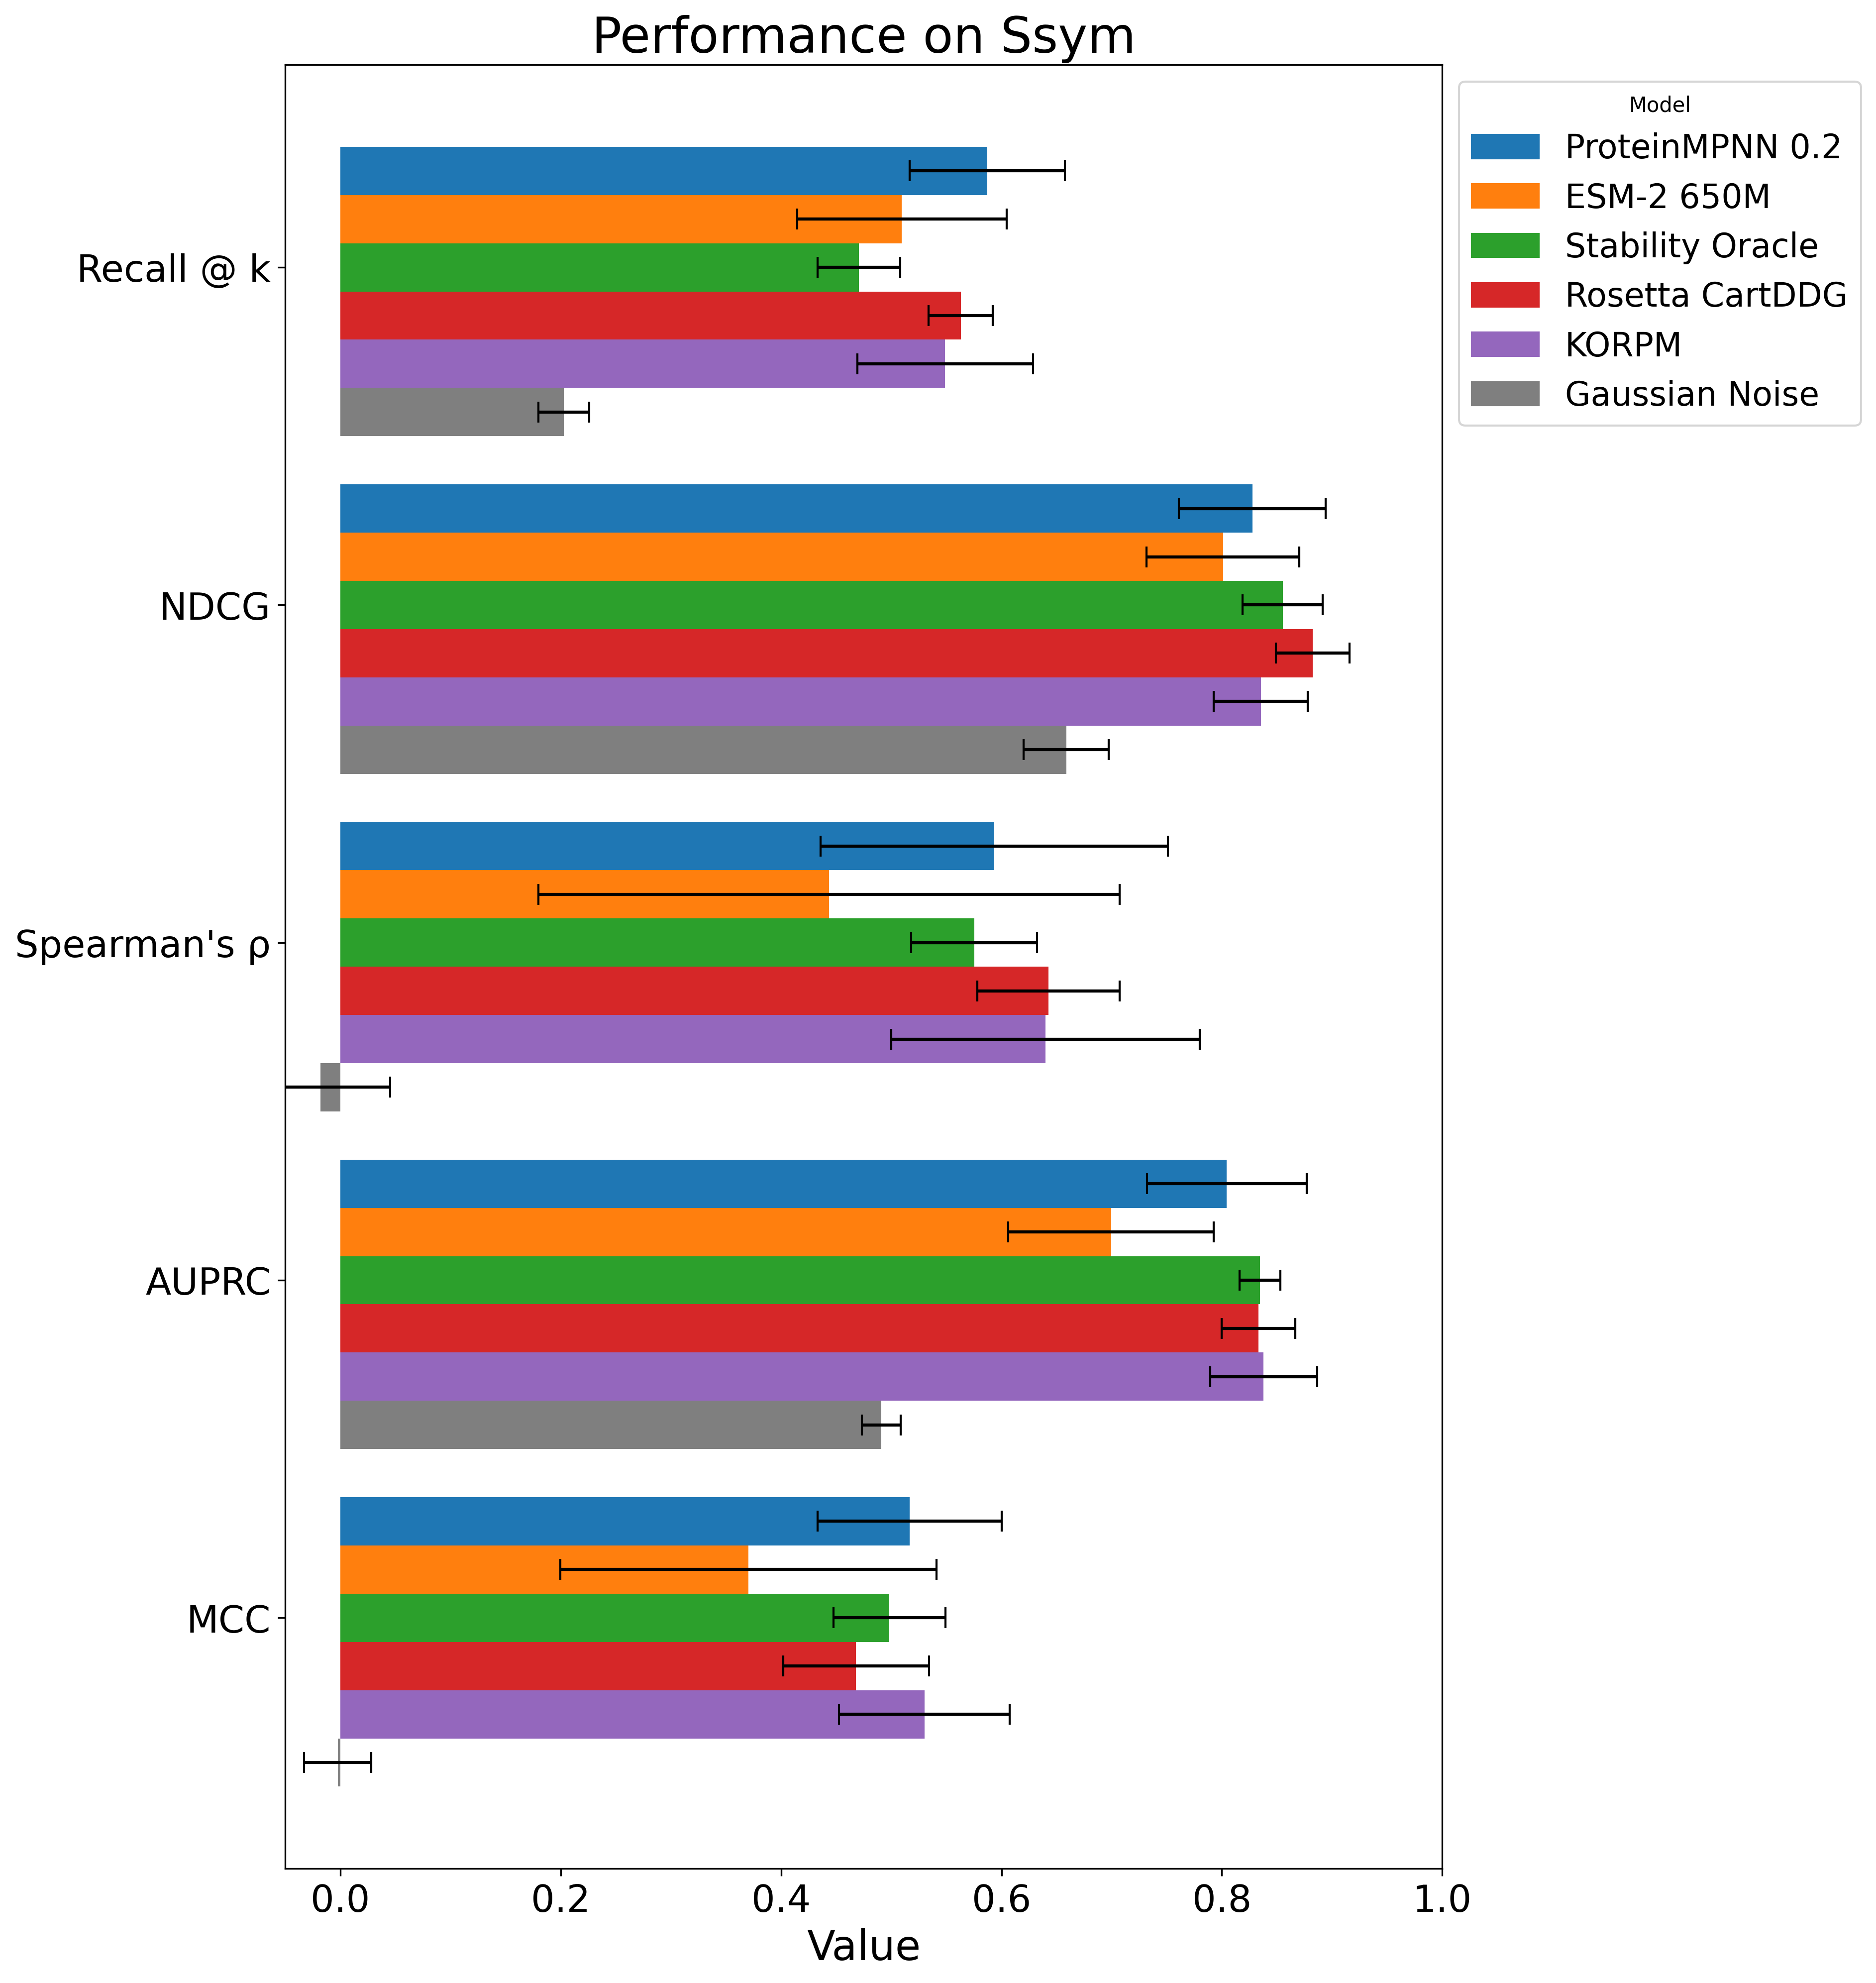

In [17]:
import importlib
importlib.reload(analysis_utils)

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

tmp3 = tmp1.copy(deep=True)#.set_index('model')
#tmp3['fractional_gain_mean'] = tmp3['net_stabilization_mean'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3['fractional_gain_std'] = tmp3['net_stabilization_std'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3 = tmp3.reset_index()
#tmp3['fractional_gain_mean']

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp3.sort_values('spearman_mean', ascending=False).dropna(how='all', axis=1).reset_index()

s4 = s2.loc[s2['model'].isin([c+'_dir' for c in original_pred_cols_reduced] + ['random_dir', 'ddG_dir', 'mpnn_rosetta_dir'])]
#s4 = s3[['model', 'n_mean', 'MCC_mean', 'MCC_std', 'auprc_mean', 'auprc_std', 'spearman_mean', 'spearman_std', 'weighted_ndcg_mean', 'weighted_ndcg_std', 'recall@k1.0_mean', 'recall@k1.0_std', 'mean_stabilization_mean', 'mean_stabilization_std']]
#s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4

tmp2 = s5[[ 'model',  
            'MCC_mean', 'MCC_std',
            'auprc_mean', 'auprc_std',
            #'weighted_spearman_mean', 'weighted_spearman_std',
            'spearman_mean', 'spearman_std',
            #'weighted_ndcg_mean', 'weighted_ndcg_std',
            'ndcg_mean', 'ndcg_std',
            'recall@k1.0_mean', 'recall@k1.0_std', 
            ]].set_index('model')

tmp2.columns = [new_remap_cols[c] for c in tmp2.columns]
tmp2 = tmp2.reset_index().drop_duplicates()

#analysis_utils.make_bar_chart(tmp2, models=['ProteinMPNN 0.2', 'ESM-2 650M', 'Stability Oracle', 'Rosetta CartDDG', 'KORPM', 'DDGun3D', 'MAESTRO', 'Gaussian Noise'], title='Q3421', xlim=(-0.5, 0.8), figsize=(24, 16))
analysis_utils.make_bar_chart(tmp2, models=['mpnn_20_00', 'esm2_650M', 'stability-oracle', 'cartesian_ddg', 'KORPM', 'random'], title='Ssym', xlim=(-0.05, 1), figsize=(10, 16))

In [18]:
"""
import importlib
importlib.reload(analysis_utils)

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

tmp3 = tmp1.copy(deep=True)#.set_index('model')
#tmp3['fractional_gain_mean'] = tmp3['net_stabilization_mean'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3['fractional_gain_std'] = tmp3['net_stabilization_std'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3 = tmp3.reset_index()
#tmp3['fractional_gain_mean']

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp3.sort_values('spearman_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s4 = s2.loc[s2['model'].isin([c+'_dir' for c in original_pred_cols_reduced] + ['random_dir', 'ddG_dir'])]
#s4 = s3[['model', 'n_mean', 'MCC_mean', 'MCC_std', 'auprc_mean', 'auprc_std', 'spearman_mean', 'spearman_std', 'weighted_ndcg_mean', 'weighted_ndcg_std', 'recall@k1.0_mean', 'recall@k1.0_std', 'mean_stabilization_mean', 'mean_stabilization_std']]
s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4

tmp2 = s5[['model', 'weighted_ndcg_mean', 'weighted_ndcg_std',
                      'weighted_spearman_mean', 'weighted_spearman_std',
                      'spearman_mean', 'spearman_std',
                      'auprc_mean', 'auprc_std', 
                      'MCC_mean', 'MCC_std',  
                      #'recall@k0.0_mean', 'recall@k0.0_std', 
                      'recall@k1.0_mean', 'recall@k1.0_std', 
                      'mean_stabilization_mean', 'mean_stabilization_std']].set_index('model')

tmp2.columns = [new_remap_cols[c] for c in tmp2.columns]
tmp2 = tmp2.reset_index().drop_duplicates()

analysis_utils.make_bar_chart(tmp2, models=['ProteinMPNN 0.2', 'ESM-2 650M', 'Stability Oracle', 'Rosetta CartDDG', 'KORPM', 'DDGun3D', 'MAESTRO', 'Gaussian Noise'], title='SSym', xlim=(-0.05, 1.5))
"""

"\nimport importlib\nimportlib.reload(analysis_utils)\n\nremap_names = analysis_utils.remap_names\nremap_names_2 = analysis_utils.remap_names_2\n\ntmp3 = tmp1.copy(deep=True)#.set_index('model')\n#tmp3['fractional_gain_mean'] = tmp3['net_stabilization_mean'] / tmp3.at['ddG_dir', 'net_stabilization_mean']\n#tmp3['fractional_gain_std'] = tmp3['net_stabilization_std'] / tmp3.at['ddG_dir', 'net_stabilization_mean']\n#tmp3 = tmp3.reset_index()\n#tmp3['fractional_gain_mean']\n\nremap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman's ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', \n    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',\n    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}\n\nnew_remap_cols = {}\nfor key, value in remap_cols.items():\n    new_remap_cols

In [19]:
tmp2

,model,MCC mean,MCC stdev,AUPRC mean,AUPRC stdev,Spearman's ρ mean,Spearman's ρ stdev,NDCG mean,NDCG stdev,Recall @ k mean,Recall @ k stdev
0,ddG,1.000000,0.000000,1.000000,1.286822e-16,1.000000,9.268665e-17,1.000000,1.945492e-16,1.000000,0.000000
1,DDG,0.931170,0.043426,0.970690,2.612520e-02,0.962897,3.608570e-02,0.994213,5.767437e-03,0.911320,0.045755
2,PremPS,0.652866,0.066820,0.911951,2.989848e-02,0.829137,6.681017e-02,0.929353,1.529362e-02,0.773073,0.030950
3,mpnn_rosetta,0.558979,0.058701,0.870379,3.193180e-02,0.702228,7.021967e-02,0.893798,3.559489e-02,0.616285,0.043216
4,cartesian_ddg,0.467982,0.066157,0.833249,3.356956e-02,0.642803,6.451711e-02,0.882548,3.347101e-02,0.563018,0.029120
5,korpm,0.530065,0.077561,0.837877,4.854069e-02,0.639936,1.400240e-01,0.835298,4.274847e-02,0.548904,0.079891
6,KORPM,0.530065,0.077561,0.837877,4.854069e-02,0.639936,1.400240e-01,0.835298,4.274847e-02,0.548904,0.079891
7,Cartddg,0.466002,0.037943,0.816912,2.973459e-02,0.616905,6.352956e-02,0.866728,2.764585e-02,0.561662,0.029615
8,mpnn_20_00,0.516562,0.083435,0.804425,7.240068e-02,0.593338,1.575407e-01,0.827652,6.654637e-02,0.586961,0.070503
9,mpnn_30_00,0.511421,0.094423,0.798230,8.440113e-02,0.587089,1.847840e-01,0.840337,6.108858e-02,0.621182,0.061809


In [20]:
# NOTE: The columns ending in % refer to the percentile-precition curve. The ones ending with $ refer to the percentile mean stability curve.
# review a custom slice of the results
class_result.loc[:, ['n', 'auprc', 'MCC', 'spearman', 'f1_score', 'auppc', 'aumsc', 'weighted_ndcg', 'weighted_spearman', 'mean_t1s', 'net_stabilization', 'mean_stabilization']].xs('combined').sort_values('spearman', ascending=False)


n     auprc       MCC  \
model_type   model                  class                              
unknown      ddG                           684.0  1.000000  1.000000   
NaN          DDG                           684.0  0.974891  0.930079   
supervised   PremPS                        684.0  0.912615  0.652518   
ensemble     mpnn_rosetta                  684.0  0.887343  0.586426   
potential    KORPM                         684.0  0.861206  0.561490   
             korpm                         684.0  0.861206  0.561490   
structural   mpnn_30_00                    684.0  0.841428  0.558004   
             mpnn_mean                     684.0  0.842980  0.554540   
             mpnn_20_00                    684.0  0.838616  0.554540   
NaN          biophysical                   684.0  0.859481  0.534309   
             structural                    684.0  0.809888  0.514454   
biophysical  cartesian_ddg                 684.0  0.849047  0.502293   
structural   mpnn_10_00                    684.0  0.823820  0.512475   
NaN          Cartddg                       684.0  0.821030  0.477890   
structural   mif_mean                      684.0  0.784747  0.447532   
NaN          supervised                    684.0  0.824934  0.409225   
transfer     ACDC-NN                       684.0  0.806222  0.400587   
evolutionary msa_transformer_mean          684.0  0.752720  0.467836   
             msa_transformer_median        684.0  0.753077  0.491228   
transfer     stability-oracle              683.0  0.843121  0.523888   
NaN          potential                     684.0  0.820862  0.507536   
structural   mifst                         684.0  0.755419  0.458689   
evolutionary esm2_15B_half                 684.0  0.769534  0.473684   
NaN          evolutionary                  684.0  0.724901  0.473684   
structural   mif                           684.0  0.790492  0.429936   
evolutionary esm2_mean                     684.0  0.742460  0.473684   
             esm2_650M                     684.0  0.742186  0.456140   
             ankh                          684.0  0.725776  0.450292   
             tranception                   684.0  0.726715  0.461988   
             esm2                          684.0  0.746749  0.467836   
transfer     ACDC-NN-Seq                   684.0  0.784715  0.326365   
structural   esmif_mean                    684.0  0.732362  0.394005   
             esmif_monomer                 684.0  0.732264  0.394005   
             esmif_multimer                684.0  0.732110  0.390653   
untrained    DDGun3D                       684.0  0.764857  0.363469   
supervised   INPS-Seq                      684.0  0.771096  0.304114   
untrained    DDGun                         684.0  0.754893  0.342435   
biophysical  FoldX                         684.0  0.749051  0.373462   
             Evo                           684.0  0.755347  0.314159   
potential    PoPMuSiC                      684.0  0.746931  0.295260   
structural   mutcomputex                   684.0  0.795507  0.425409   
supervised   INPS3D                        684.0  0.728129  0.304134   
unknown      Dynamut                       684.0  0.724358  0.371359   
evolutionary esm1v_mean                    684.0  0.667571  0.327485   
             esm1v_median                  684.0  0.663764  0.321637   
             esm2_150M                     684.0  0.673469  0.345029   
supervised   ThermoNet                     678.0  0.698605  0.241911   
             I-Mutant3.0-Seq               682.0  0.739869  0.287891   
             MAESTRO                       684.0  0.701773  0.233007   
             DUET                          684.0  0.705469  0.268904   
             I-Mutant3.0                   682.0  0.684529  0.231836   
             MUpro                         684.0  0.671342  0.254778   
             mCSM                          684.0  0.654094  0.146946   
unknown      delta_vol                     684.0  0.638833  0.231019   
potential    SD

In [21]:
#importlib.reload(analysis_utils)
# extra figure (not in text)
#class_result_new = analysis_utils.compute_stats_bidirectional(db_class, stats=('aumsc', 'auppc'), grouper='uid', stacked=True)
#analysis_utils.recovery_curves_2(class_result_new, ['ens', 'mpnn_20_00', 'cartesian_ddg', 'test', 'ddG', 'random'], percentile_labels=[90], directions=['dir','inv'])

In [22]:
zs_feats = ['delta_kdh', 'delta_vol', 'rel_ASA']
#red_cols = [c[:-4] for c in original_pred_cols_reduced]

#models = original_pred_cols_reduced + [c + '_dir' for c in zs_feats]
#models += [c.replace('_dir', '_inv') for c in models]
#print(models)
models = list(db_class.columns)

db_ens = db_class.copy(deep=True)
db_ens = db_ens[models]

print(len(db_ens))
db_ens['random'] = np.random.rand(len(db_ens)) - 0.5
#db_ens['random_inv'] = np.random.rand(len(db_ens)) - 0.5
#db_ens = db_ens.drop(['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir', 'TNetD_dir', 'ACDCNND_dir'], axis=1)
dfm = db_ens.copy(deep=True)

def unstack_frames(df):
    df_dir = df.xs('dir')
    df_dir.columns = [c + '_dir' for c in df_dir.columns]
    df_inv = df.xs('inv')
    df_inv.columns = [c + '_inv' for c in df_inv.columns]
    return df_dir.join(df_inv)
dfu = unstack_frames(dfm)

weights = [1, 0.5, 0.2]
#weights2 = [0.8, 0.3]

all_cols = []

tmp = []
for model1 in models:
    for model2 in models:
        if model1 != model2: #(model1.split('_')[0] != model2.split('_')[0]) and (model1[:4] != model2[:4]) and
            for weight in weights:
                tmp.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #for model3 in models:
                #    if model2 != model3 and model1 != model3:
                #        for weight2 in weights2:
                #            tmp.append(pd.Series(dfm[model1] + dfm[model2] * weight + dfm[model3] * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                #            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')

dfm = pd.concat([dfm] + tmp, axis=1)
#dfm = dfm.join(db_stacked_runtimes)
dfm
#dfm.to_csv(os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_preds.csv'))
#dfm

684


,,ACDC-NN,ACDC-NN-Seq,Cartddg,DDG,DDGun,DDGun3D,DUET,Dynamut,Dynamut2,Evo,...,random + mpnn_mean * 0.2,random + esmif_mean * 1,random + esmif_mean * 0.5,random + esmif_mean * 0.2,random + mif_mean * 1,random + mif_mean * 0.5,random + mif_mean * 0.2,random + esm2_mean * 1,random + esm2_mean * 0.5,random + esm2_mean * 0.2
direction,uid,,,,,,,,,,,,,,,,,,,,,
dir,1AMQ_191F,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,-1.34,-0.43,...,-0.159199,-0.195301,-0.017352,0.089417,-2.374509,-1.106956,-0.346424,-1.343451,-0.591427,-0.140213
inv,1AMQ_191F,-0.179437,0.000000,-2.74,1.6,-1.0,-1.0,-1.735,-0.727,-2.07,-0.16,...,0.729132,0.464006,0.447412,0.437456,1.991557,1.211188,0.742966,1.934867,1.182843,0.731628
dir,1AMQ_191S,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,-2.18,-1.18,...,-0.858854,-0.819368,-0.799563,-0.787681,-1.882417,-1.331088,-1.000290,-1.779630,-1.279694,-0.979733
inv,1AMQ_191S,0.150363,0.000000,2.98,1.9,-0.2,0.4,-0.375,1.315,-1.60,0.92,...,0.631511,0.662644,0.630321,0.610926,1.638926,1.118461,0.806183,1.597868,1.097933,0.797971
dir,1AMQ_191W,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,-1.75,0.24,...,-1.227432,-1.347737,-1.124065,-0.989862,-4.043811,-2.472102,-1.529076,-2.682967,-1.791680,-1.256908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
inv,5PTI_35G,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,-0.55,0.81,...,0.747667,-5.444472,-2.164274,-0.196155,0.082295,0.599110,0.909198,2.248154,1.682039,1.342370
dir,5PTI_43G,-1.785572,-1.548846,-8.00,-5.7,-2.1,-1.9,-2.580,-1.420,-3.05,-3.00,...,0.313918,-6.192893,-2.750342,-0.684811,-1.843848,-0.575819,0.184998,-0.403975,0.144117,0.472972
inv,5PTI_43G,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,-0.56,1.96,...,0.222630,1.016137,0.456455,0.120645,1.638461,0.767617,0.245110,0.992956,0.444864,0.116009


In [23]:
def get_summary_df(db_complete, cols=None, saveloc=os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_results.csv'), stats=(), stacked=False):

    assert os.path.exists(os.path.dirname(saveloc))
    #assert not os.path.exists(saveloc)
    #if cols is None:
    #    cols = db_complete.columns.drop(['code'])#, 'ddG_dir', 'ddG_inv'])

    if not stacked:
        db_stacked = analysis_utils.stack_frames(db_complete)
    else:
        db_stacked = db_complete
    #db_stacked['code'] = list(db_stacked.reset_index()['uid'].str[:4])
    #print(db_stacked)

    df_summ = analysis_utils.compute_stats_bidirectional(db_stacked, stacked=True, stats=(), grouper='cluster', directions=['dir', 'inv']).reset_index().set_index(['direction', 'model'])#.join(df_reg) #.drop('n_total', axis=1))
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1).set_index(['direction', 'model_type', 'model', 'class'])
    df_summ = df_summ.sort_index(level=1).sort_index(level=0)#.drop_duplicates()
    df_summ.to_csv(saveloc)
    return df_summ

In [24]:
import importlib
importlib.reload(analysis_utils)
# takes a long time to compute and has already been done
#dfm_stacked = analysis_utils.stack_frames(dfm)
#dfm_stacked = dfm_stacked.reset_index().set_index('uid').join(db_clusters).reset_index().set_index(['direction', 'uid'])
#dfm_stacked['code'] = list(dfm_stacked.reset_index()['uid'].str[:4])
#dd = dfm.join(db_clusters).rename({'cluster': 'cluster_dir'}, axis=1).join(db_clusters).rename({'cluster': 'cluster_inv'}, axis=1)#.join(db_ddgs_2)
#dd['code'] = dd.index.str[:4]
#d1 = get_summary_df(dfm, saveloc=os.path.join(path, 'data', 'ensemble_ssym_2_models_3_weights_revisions_runtimes_2.csv'), stats=(), stacked=True) 

d1 = pd.read_csv(os.path.join(path, 'data', 'ensemble_ssym_2_models_3_weights_revisions_runtimes_2.csv')).set_index(['direction', 'model_type', 'model', 'class'])

In [30]:
dfu_ = dfu.join(db_stacked_runtimes)
dfu_

ACDC-NN_dir  ACDC-NN-Seq_dir  Cartddg_dir  DDG_dir  \
direction uid                                                             
dir       1AMQ_191F     0.155387         0.000000        -8.00     -1.6   
          1AMQ_191S    -0.310174         0.000000        -4.22     -1.9   
          1AMQ_191W     0.175478         0.000235        -8.00     -3.9   
          1AMQ_191Y     0.255306         0.007419        -7.80     -2.3   
          1BNI_14A     -1.032232        -1.280774        -8.00     -4.5   
...                          ...              ...          ...      ...   
inv       5PTI_22A     -1.802440        -1.794489        -6.23     -1.2   
          5PTI_23A     -3.107841        -2.997760        -8.00     -5.9   
          5PTI_35G     -3.815977        -3.124952        -8.00     -5.0   
          5PTI_43G     -1.785572        -1.548846        -8.00     -5.7   
          5PTI_45A     -3.439780        -3.219905        -8.00     -6.9   

                     DDGun_dir  DDGun3D_dir  DUET_dir  Dynamut_dir  \
direction uid                                                        
dir       1AMQ_191F        0.9          0.9    -0.992        0.800   
          1AMQ_191S        0.2         -0.5    -1.717       -0.149   
          1AMQ_191W        1.1          1.0    -1.495        1.222   
          1AMQ_191Y        1.3          1.3    -1.307        1.210   
          1BNI_14A        -3.1         -3.1    -3.172       -2.526   
...                        ...          ...       ...          ...   
inv       5PTI_22A        -2.6         -2.5    -3.573       -1.876   
          5PTI_23A        -4.2         -4.0    -3.980       -3.729   
          5PTI_35G        -4.5         -4.4    -4.156       -3.250   
          5PTI_43G        -2.1         -1.9    -2.580       -1.420   
          5PTI_45A        -5.3         -4.4    -3.734       -3.474   

                     Dynamut2_dir  Evo_dir  ...  runtime_mpnn_20_00  \
direction uid                               ...                       
dir       1AMQ_191F         -1.34    -0.43  ...            0.016232   
          1AMQ_191S         -2.18    -1.18  ...            0.014761   
          1AMQ_191W         -1.75     0.24  ...            0.014751   
          1AMQ_191Y         -1.23    -3.15  ...            0.015225   
          1BNI_14A          -2.34    -2.93  ...            0.008188   
...                           ...      ...  ...                 ...   
inv       5PTI_22A          -3.01    -3.13  ...            0.008387   
          5PTI_23A          -3.86    -3.57  ...            0.007620   
          5PTI_35G          -3.94    -4.04  ...            0.007639   
          5PTI_43G          -3.05    -3.00  ...            0.008101   
          5PTI_45A          -3.22    -3.35  ...            0.007606   

                     runtime_mpnn_30_00  runtime_msa_1  runtime_msa_2  \
direction uid                                                           
dir       1AMQ_191F            0.016989       3.390493       3.497325   
          1AMQ_191S            0.016065       3.393482       3.394148   
          1AMQ_191W            0.016062       3.393750       3.387580   
          1AMQ_191Y            0.016026       3.397354       3.391266   
          1BNI_14A             0.008603       1.350701       1.348936   
...                                 ...            ...            ...   
inv       5PTI_22A             0.007817       0.882186       0.882716   
          5PTI_23A             0.007565       1.026886       0.895081   
          5PTI_35G             0.007818       0.881158       0.881511   
          5PTI_43G             0.008260       0.881816       0.880770   
          5PTI_45A             0.007539       0.881755       0.881217   

                     runtime_msa_3  runtime_msa_4  runtime_msa_5  \
direction uid                                                      
dir       1AMQ_191F       3.481303       3.485137       3.457739   
          1AMQ_191S       3.398332       3.395951       

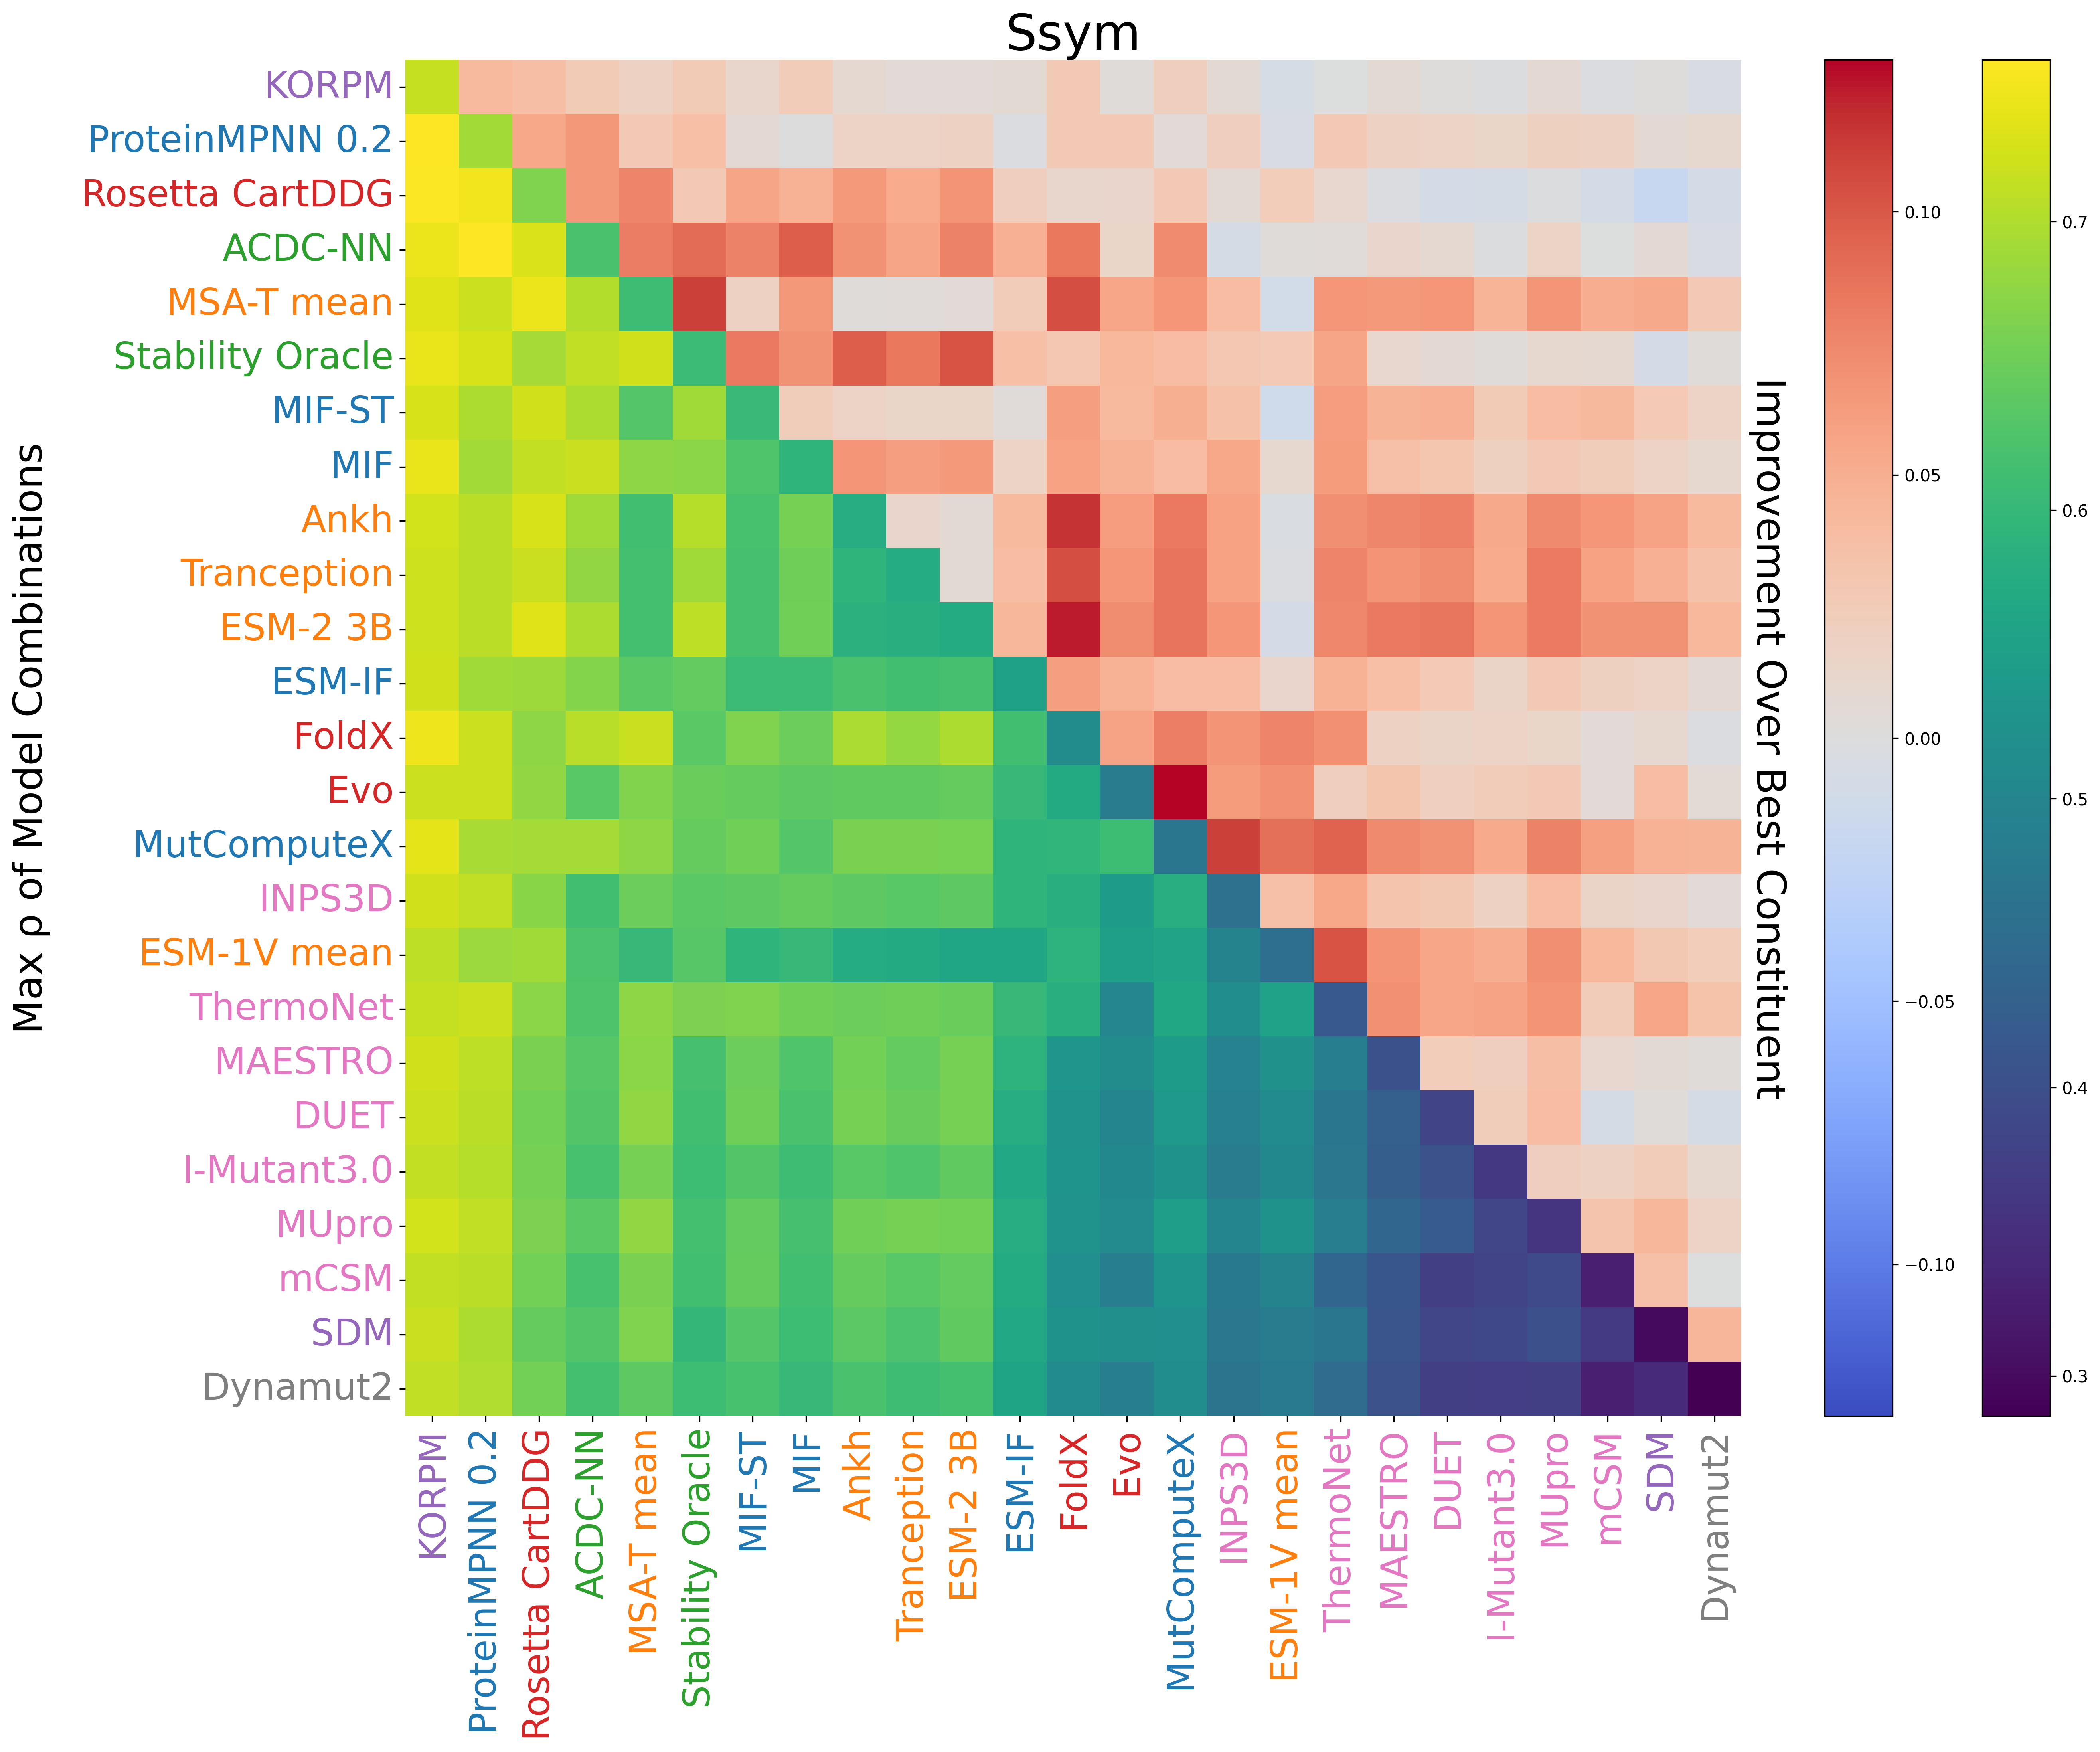

{'INPS3D', 'tranception', 'Evo', 'ankh', 'mifst', 'esm2', 'mif', 'stability-oracle', 'ThermoNet', 'FoldX', 'msa_transformer_mean', 'MAESTRO', 'mutcomputex', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'MUpro', 'mpnn_20_00', 'KORPM'}


,model1,weight1,model2,weight2,spearman,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,KORPM,1.0,mpnn_20_00,0.5,0.755972,0.714950,1.0259,6.108144
2,ACDC-NN,1.0,mpnn_20_00,1.0,0.755558,0.584479,-0.0001,6.108144
3,KORPM,1.0,cartesian_ddg,1.0,0.753333,0.662762,216509.0259,-0.000100
4,cartesian_ddg,1.0,mpnn_20_00,1.0,0.745455,0.634668,216507.9999,6.108144
5,KORPM,1.0,FoldX,0.5,0.743656,0.450146,1.0259,-0.000100
...,...,...,...,...,...,...,...,...
321,Dynamut2,1.0,SDM,1.0,0.342694,0.425244,-0.0001,-0.000100
322,mCSM,1.0,mCSM,0.0,0.328077,1.000000,-0.0001,-0.000100
323,mCSM,1.0,Dynamut2,0.2,0.327839,0.816947,-0.0001,-0.000100


In [32]:
importlib.reload(analysis_utils)

subset = [#'ACDC-NN-Seq', 
        'ACDC-NN', 
        'DDGun'
        'DDGun3D',
        'DUET',
        'Dynamut2',
        'FoldX',
        'Evo',
        'I-Mutant3.0',
        #'I-Mutant3.0-Seq',
        #'INPS-Seq',
        'INPS3D',
        'MAESTRO',
        'MUpro',
        'PopMusic',
        #'PremPS',
        'ThermoNet',
        'SAAFEC-Seq',
        'SDM',
        #'SOL_ACC',
        #'delta_kdh',
        #'delta_vol',
        #'abs_ASA',
        'ThermoNet',
        'mCSM',
        'cartesian_ddg',
        'esm1v_mean',
        #'esm2_mean',
        'esm2',
        'ankh',
        'msa_transformer_mean',
        'tranception',
        #'esmif_monomer',
        'esmif_multimer',
        'KORPM',
        'mpnn_20_00',
        'mif',
        'mifst',
        #'mpnn_mean',
        #'esmif_mean',
        #'mif_mean',
        'stability-oracle',
        'mutcomputex']

direction = 'combined'
statistic = 'spearman'
upper = 'delta'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfu_, statistic, direction, upper, subset=subset, annot=False, title='Ssym')
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
stat_df

In [ ]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
stat_df_.to_csv('../data/stat_df_ssym.csv')
stat_df_

,Rank,Base model,Added Model,Weight,Spearman's rho,Model Correlation,CPU time (s),GPU time (s)
0,1,KORPM,ProteinMPNN 0.2,0.5,0.76,0.71,0.34,2.73
1,2,ACDC-NN,ProteinMPNN 0.2,1.0,0.76,0.58,-0.00,2.73
2,3,KORPM,Rosetta CartDDG,1.0,0.75,0.66,62596.34,-0.00
3,4,Rosetta CartDDG,ProteinMPNN 0.2,1.0,0.75,0.63,62596.00,2.73
4,5,KORPM,FoldX,0.5,0.74,0.45,0.34,-0.00
...,...,...,...,...,...,...,...,...
320,321,Dynamut2,SDM,1.0,0.34,0.43,-0.00,-0.00
321,322,mCSM,mCSM,0.0,0.33,1.00,-0.00,-0.00
322,323,mCSM,Dynamut2,0.2,0.33,0.82,-0.00,-0.00
323,324,SDM,SDM,0.0,0.30,1.00,-0.00,-0.00


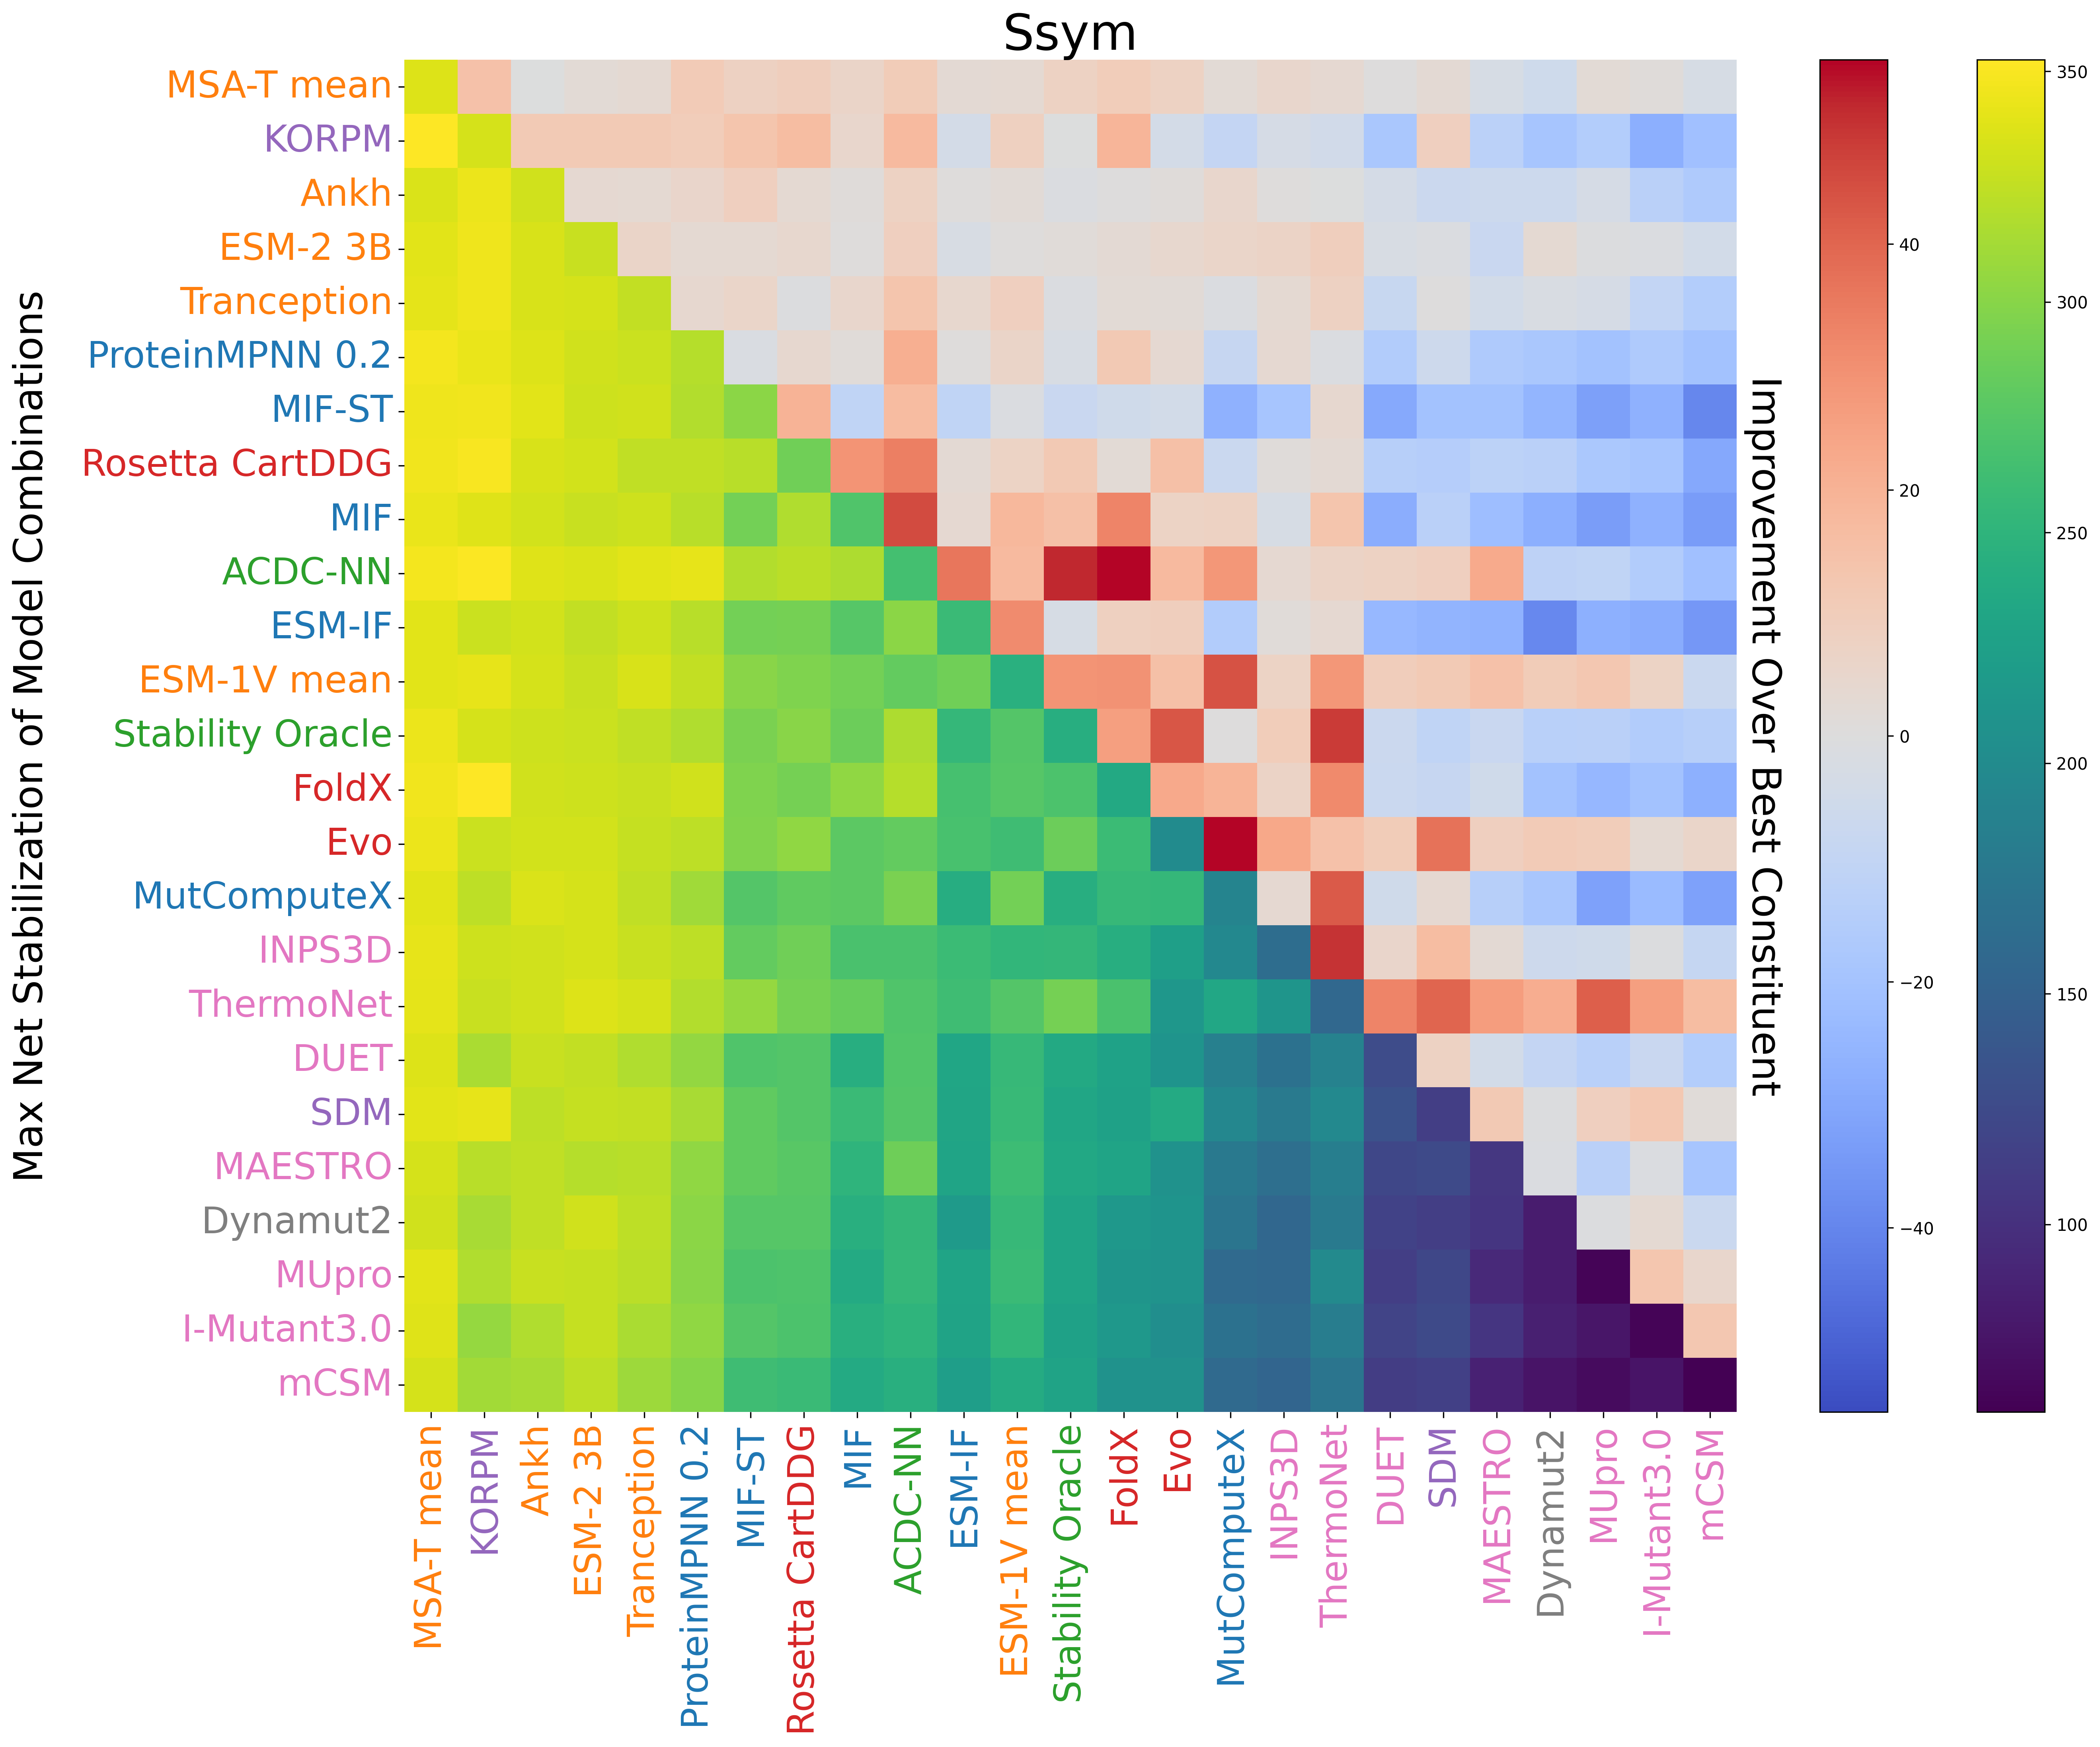

{'mif', 'INPS3D', 'FoldX', 'tranception', 'ACDC-NN', 'ThermoNet', 'ankh', 'esm2', 'esmif_multimer', 'SDM', 'mifst', 'Evo', 'cartesian_ddg', 'mutcomputex', 'MUpro', 'esm1v_mean', 'KORPM', 'mpnn_20_00', 'stability-oracle', 'msa_transformer_mean'}


,model1,weight1,model2,weight2,net_stabilization,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,KORPM,1.0,FoldX,0.5,352.481,0.450146,0.3419,-0.000100
2,KORPM,1.0,msa_transformer_mean,0.2,351.551,0.660584,0.3419,2434.181651
3,KORPM,1.0,ACDC-NN,0.2,350.403,0.684548,0.3419,-0.000100
4,KORPM,1.0,cartesian_ddg,0.5,349.913,0.662762,62596.3419,-0.000100
5,msa_transformer_mean,1.0,mpnn_20_00,0.5,347.661,0.658826,-0.0001,2436.911847
...,...,...,...,...,...,...,...,...
319,Dynamut2,1.0,mCSM,0.2,74.399,0.816947,-0.0001,-0.000100
320,MUpro,1.0,mCSM,0.5,67.629,0.529011,-0.0001,-0.000100
321,MUpro,1.0,MUpro,0.0,62.590,1.000000,-0.0001,-0.000100


In [ ]:
importlib.reload(analysis_utils)

subset = [#'ACDC-NN-Seq', 
        'ACDC-NN', 
        'DDGun'
        'DDGun3D',
        'DUET',
        'Dynamut2',
        'FoldX',
        'Evo',
        'I-Mutant3.0',
        #'I-Mutant3.0-Seq',
        #'INPS-Seq',
        'INPS3D',
        'MAESTRO',
        'MUpro',
        'PopMusic',
        #'PremPS',
        'ThermoNet',
        'SAAFEC-Seq',
        'SDM',
        #'SOL_ACC',
        #'delta_kdh',
        #'delta_vol',
        #'abs_ASA',
        'ThermoNet',
        'mCSM',
        'cartesian_ddg',
        'esm1v_mean',
        #'esm2_mean',
        'esm2',
        'ankh',
        'msa_transformer_mean',
        'tranception',
        #'esmif_monomer',
        'esmif_multimer',
        'KORPM',
        'mpnn_20_00',
        'mif',
        'mifst',
        #'mpnn_mean',
        #'esmif_mean',
        #'mif_mean',
        'stability-oracle',
        'mutcomputex']

direction = 'combined'
statistic = 'net_stabilization'
upper = 'delta'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfu_, statistic, direction, upper, subset=subset, annot=False, title='Ssym')
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
stat_df

In [ ]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
stat_df_.to_csv('../data/stat_df_net_stab_ssym.csv')
stat_df_

,Rank,Base model,Added Model,Weight,net_stabilization,Model Correlation,CPU time (s),GPU time (s)
0,1,KORPM,FoldX,0.5,352.48,0.45,0.34,-0.00
1,2,KORPM,MSA-T mean,0.2,351.55,0.66,0.34,2434.18
2,3,KORPM,ACDC-NN,0.2,350.40,0.68,0.34,-0.00
3,4,KORPM,Rosetta CartDDG,0.5,349.91,0.66,62596.34,-0.00
4,5,MSA-T mean,ProteinMPNN 0.2,0.5,347.66,0.66,-0.00,2436.91
...,...,...,...,...,...,...,...,...
318,319,Dynamut2,mCSM,0.2,74.40,0.82,-0.00,-0.00
319,320,MUpro,mCSM,0.5,67.63,0.53,-0.00,-0.00
320,321,MUpro,MUpro,0.0,62.59,1.00,-0.00,-0.00
321,322,I-Mutant3.0,I-Mutant3.0,0.0,62.43,1.00,-0.00,-0.00


{'model1': ['ACDC-NN', 'ACDC-NN', 'ACDC-NN', 'ACDC-NN-Seq', 'ACDC-NN', 'DDGun3D', 'ACDC-NN', 'DUET', 'ACDC-NN', 'Dynamut2', 'ACDC-NN', 'Evo', 'ACDC-NN', 'I-Mutant3.0', 'ACDC-NN', 'I-Mutant3.0-Seq', 'ACDC-NN', 'INPS-Seq', 'ACDC-NN', 'INPS3D', 'KORPM', 'ACDC-NN', 'ACDC-NN', 'MAESTRO', 'ACDC-NN', 'MUpro', 'ACDC-NN', 'SDM', 'ACDC-NN', 'ankh', 'ACDC-NN', 'esm1v_mean', 'ACDC-NN', 'esm2_mean', 'ACDC-NN', 'msa_transformer_mean', 'ACDC-NN', 'tranception', 'ACDC-NN', 'ThermoNet', 'ACDC-NN', 'cartesian_ddg', 'ACDC-NN', 'esmif_mean', 'ACDC-NN', 'mCSM', 'ACDC-NN', 'mif_mean', 'ACDC-NN', 'mpnn_mean', 'ACDC-NN-Seq', 'ACDC-NN-Seq', 'ACDC-NN-Seq', 'DDGun3D', 'ACDC-NN-Seq', 'DUET', 'ACDC-NN-Seq', 'Dynamut2', 'ACDC-NN-Seq', 'Evo', 'ACDC-NN-Seq', 'I-Mutant3.0', 'ACDC-NN-Seq', 'I-Mutant3.0-Seq', 'ACDC-NN-Seq', 'INPS-Seq', 'ACDC-NN-Seq', 'INPS3D', 'KORPM', 'ACDC-NN-Seq', 'ACDC-NN-Seq', 'MAESTRO', 'ACDC-NN-Seq', 'MUpro', 'ACDC-NN-Seq', 'SDM', 'ACDC-NN-Seq', 'ankh', 'ACDC-NN-Seq', 'esm1v_mean', 'ACDC-NN-Seq',

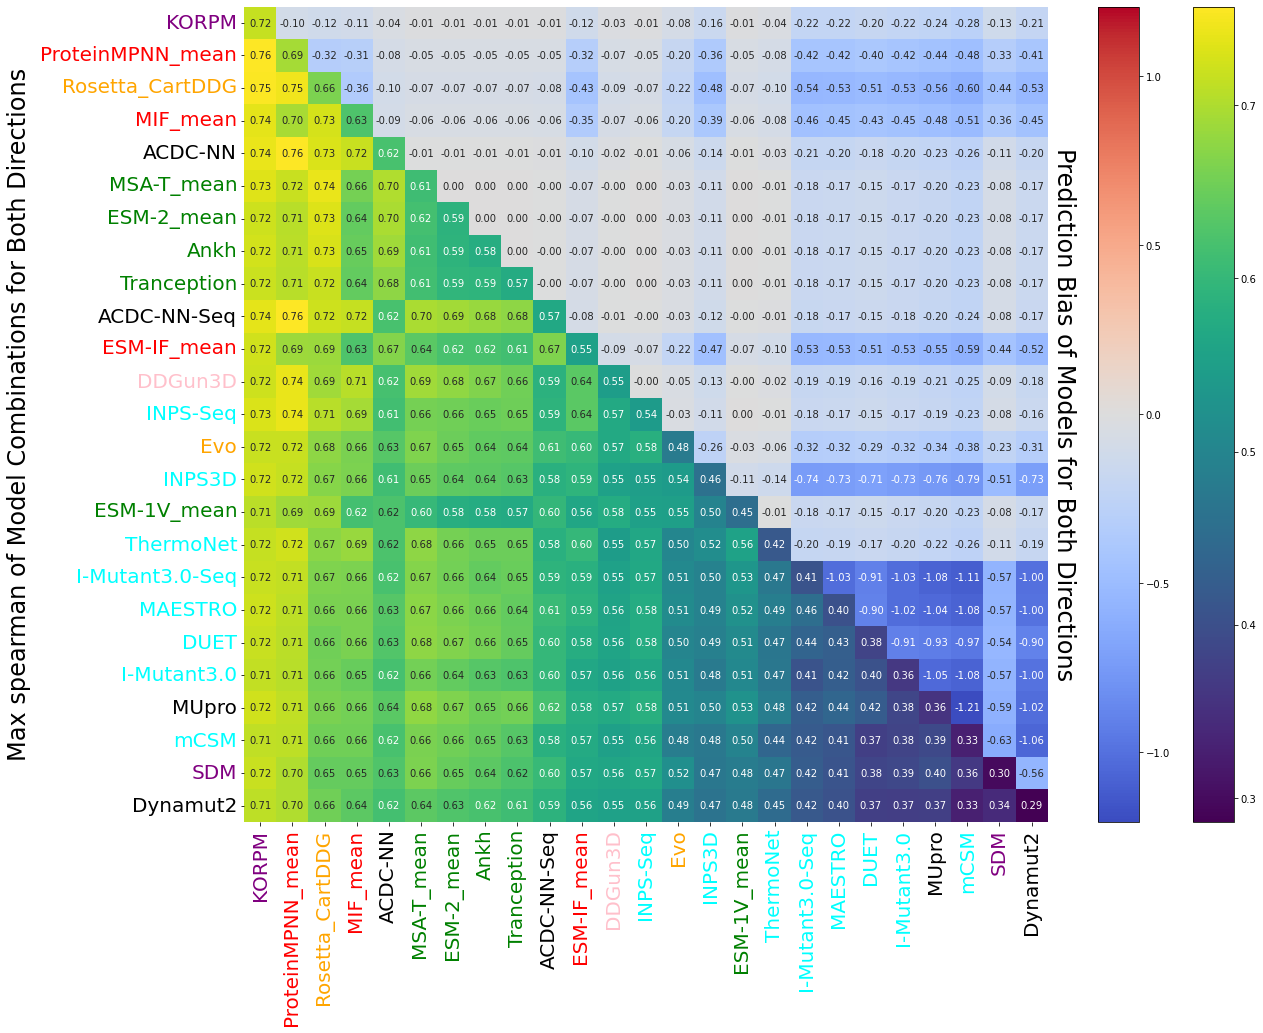

{'MAESTRO', 'cartesian_ddg', 'mif_mean', 'INPS-Seq', 'MUpro', 'tranception', 'INPS3D', 'esm2_mean', 'ThermoNet', 'ACDC-NN-Seq', 'ACDC-NN', 'msa_transformer_mean', 'ankh', 'mpnn_mean', 'KORPM', 'esmif_mean', 'Evo', 'DDGun3D'}


,model1,weight1,model2,weight2,spearman,corr
rank,,,,,,
1,ACDC-NN,1.0,mpnn_mean,1.0,0.756935,0.583355
2,ACDC-NN-Seq,1.0,mpnn_mean,1.0,0.756903,0.544716
3,KORPM,1.0,mpnn_mean,1.0,0.755288,0.722875
4,KORPM,1.0,cartesian_ddg,1.0,0.753333,0.662762
5,cartesian_ddg,1.0,mpnn_mean,1.0,0.746578,0.626128
...,...,...,...,...,...,...
321,Dynamut2,1.0,SDM,1.0,0.342694,0.425244
322,mCSM,1.0,mCSM,0.0,0.328077,1.000000
323,mCSM,1.0,Dynamut2,0.2,0.327839,0.816947


In [ ]:
importlib.reload(analysis_utils)

custom_colors = {'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 'DUET': 'purple',
                 'Dynamut2': 'orange',
                 'FoldX': 'red',
                 'Evo': 'green',
                 'I-Mutant3.0': 'orange',
                 'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 'MUpro': 'red',
                 'PopMusic': 'red',
                 #'PremPS': 'purple',
                 'ThermoNet': 'purple',
                 'SAAFEC-Seq': 'orange',
                 'SDM': 'purple',
                 'SOL_ACC': 'red',
                 #'delta_kdh': 'blue',
                 #'delta_vol': 'blue',
                 #'abs_ASA': 'red',
                 'ThermoNet': 'red',
                 'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'esm2_mean': 'blue',
                 'ankh': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception': 'blue',
                 #'esmif_monomer': 'red',
                 #'esmif_multimer': 'red',
                 'KORPM': 'red',
                 #'mpnn_20_00': 'red',
                 #'mif': 'red',
                 #'mifst': 'purple',
                 'mpnn_mean': 'red',
                 'esmif_mean': 'red',
                 'mif_mean': 'red'
                 }

direction = 'combined'
statistic = 'spearman'
upper = 'bias'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, db_ens, statistic, direction, upper, subset=list(custom_colors.keys())) #threshold=0
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
stat_df

In [ ]:
supp = d1.xs('dir')[['auprc', 'mean_stabilization', 'net_stabilization', 'weighted_ndcg', 'weighted_spearman', 'auppc', 'aumsc', 'antisymmetry', 'bias']].reset_index().drop(['model_type', 'class'], axis=1)#.set_index('model')
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='dir')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

{'model1': ['ACDC-NN', 'ACDC-NN', 'DDGun3D', 'ACDC-NN', 'ACDC-NN', 'DUET', 'ACDC-NN', 'Dynamut', 'I-Mutant3.0', 'ACDC-NN', 'I-Mutant3.0-Seq', 'ACDC-NN', 'ACDC-NN', 'INPS3D', 'MAESTRO', 'ACDC-NN', 'PremPS', 'ACDC-NN', 'ACDC-NN', 'SDM', 'ddG', 'ACDC-NN', 'ACDC-NN', 'esm1v_mean', 'msa_transformer_mean', 'ACDC-NN', 'tranception', 'ACDC-NN', 'ACDC-NN', 'ThermoNet', 'ACDC-NN', 'cartesian_ddg', 'esmif_monomer', 'ACDC-NN', 'esmif_multimer', 'ACDC-NN', 'korpm', 'ACDC-NN', 'ACDC-NN', 'mCSM', 'mif', 'ACDC-NN', 'ACDC-NN', 'mifst', 'ACDC-NN', 'mpnn_20_00', 'ACDC-NN', 'mpnn_mean', 'DDGun3D', 'DDGun3D', 'DDGun3D', 'DUET', 'DDGun3D', 'Dynamut', 'I-Mutant3.0', 'DDGun3D', 'DDGun3D', 'I-Mutant3.0-Seq', 'DDGun3D', 'INPS3D', 'MAESTRO', 'DDGun3D', 'PremPS', 'DDGun3D', 'DDGun3D', 'SDM', 'ddG', 'DDGun3D', 'DDGun3D', 'esm1v_mean', 'msa_transformer_mean', 'DDGun3D', 'DDGun3D', 'tranception', 'DDGun3D', 'ThermoNet', 'cartesian_ddg', 'DDGun3D', 'esmif_monomer', 'DDGun3D', 'DDGun3D', 'esmif_multimer', 'DDGun3D', '

,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization
390,ddG,ddG,0.0,1.000000,0.107285,57.531
396,ddG,Tranception,0.2,0.999368,0.107285,54.400
332,ddG,PremPS,0.2,0.999322,0.100477,57.420
230,ddG,I-Mutant3.0-Seq,0.2,0.998284,0.088828,53.000
192,ddG,I-Mutant3.0,0.2,0.998101,0.088828,53.400
400,ddG,Rosetta_CartDDG,0.2,0.997980,0.100967,56.601
152,ddG,Dynamut,0.2,0.997672,0.101495,56.551
300,ddG,MAESTRO,0.2,0.997624,0.095672,56.610
362,ddG,SDM,0.2,0.997435,0.100390,55.561
406,ddG,KORPM,0.2,0.997269,0.098400,55.899


KeyError: "None of [Index(['model1', 'model2'], dtype='object')] are in the [columns]"

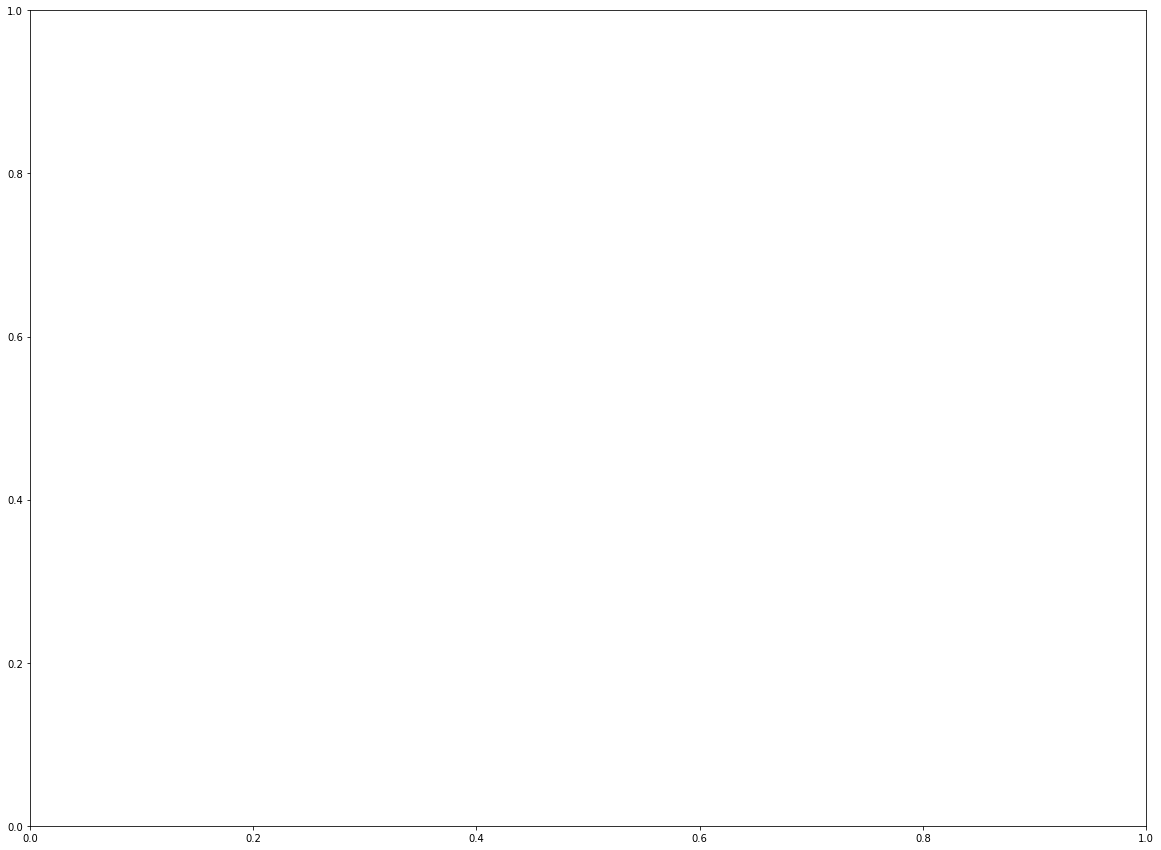

In [ ]:
direction = 'combined'
statistic = 'weighted_spearman'
upper = 'bias'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, db_ens, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
#out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

In [ ]:
supp = d1.xs('combined')[['auprc', 'weighted_ndcg', 'weighted_spearman', 'mean_stabilization', 'net_stabilization', 'auppc', 'aumsc']].reset_index().drop(['model_type', 'class'], axis=1)
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

DDGun ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
tranception ddG e
FoldX ddG e
cartesian_ddg ddG e
ddG esmif_monomer e
ddG esmif_multimer e
ddG korpm e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
DDGun ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
tranception ddG e
FoldX ddG e
cartesian_ddg ddG e
ddG esmif_monomer e
ddG esmif_multimer e
ddG korpm e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
DDGun ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
tranception ddG e
FoldX ddG e
cartesian_ddg ddG e
ddG esmif_monomer e
ddG esmif_multimer e
ddG korpm e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
18


,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization
114,ddG,ddG,0.0,1.000000,0.547855,429.903
92,FoldX,KORPM,1.0,0.958794,0.446504,331.451
98,FoldX,ProteinMPNN_20,0.5,0.956635,0.442794,305.792
106,Rosetta_CartDDG,KORPM,0.2,0.955378,0.458321,333.103
112,Rosetta_CartDDG,ProteinMPNN_20,0.2,0.954545,0.454116,306.993
108,Rosetta_CartDDG,MIF,0.5,0.953525,0.444871,304.893
22,DDGun,ProteinMPNN_20,0.5,0.949994,0.464096,320.093
50,FoldX,MSA-T_mean,0.2,0.949426,0.455115,329.439
110,Rosetta_CartDDG,MIF-ST,0.2,0.949262,0.447400,300.743
96,FoldX,MIF-ST,0.5,0.948266,0.432487,284.153


In [ ]:
rand = class_result.reset_index()
rand = rand.loc[rand['model'].str.contains('random')]
rand['model'] = 'random'
rand['model_type'] = np.nan
rand = rand.set_index(['direction', 'model_type', 'model'])
dr = pd.concat([d1.reset_index(), rand.reset_index()])
dr = dr.set_index(['direction', 'model_type', 'model'])

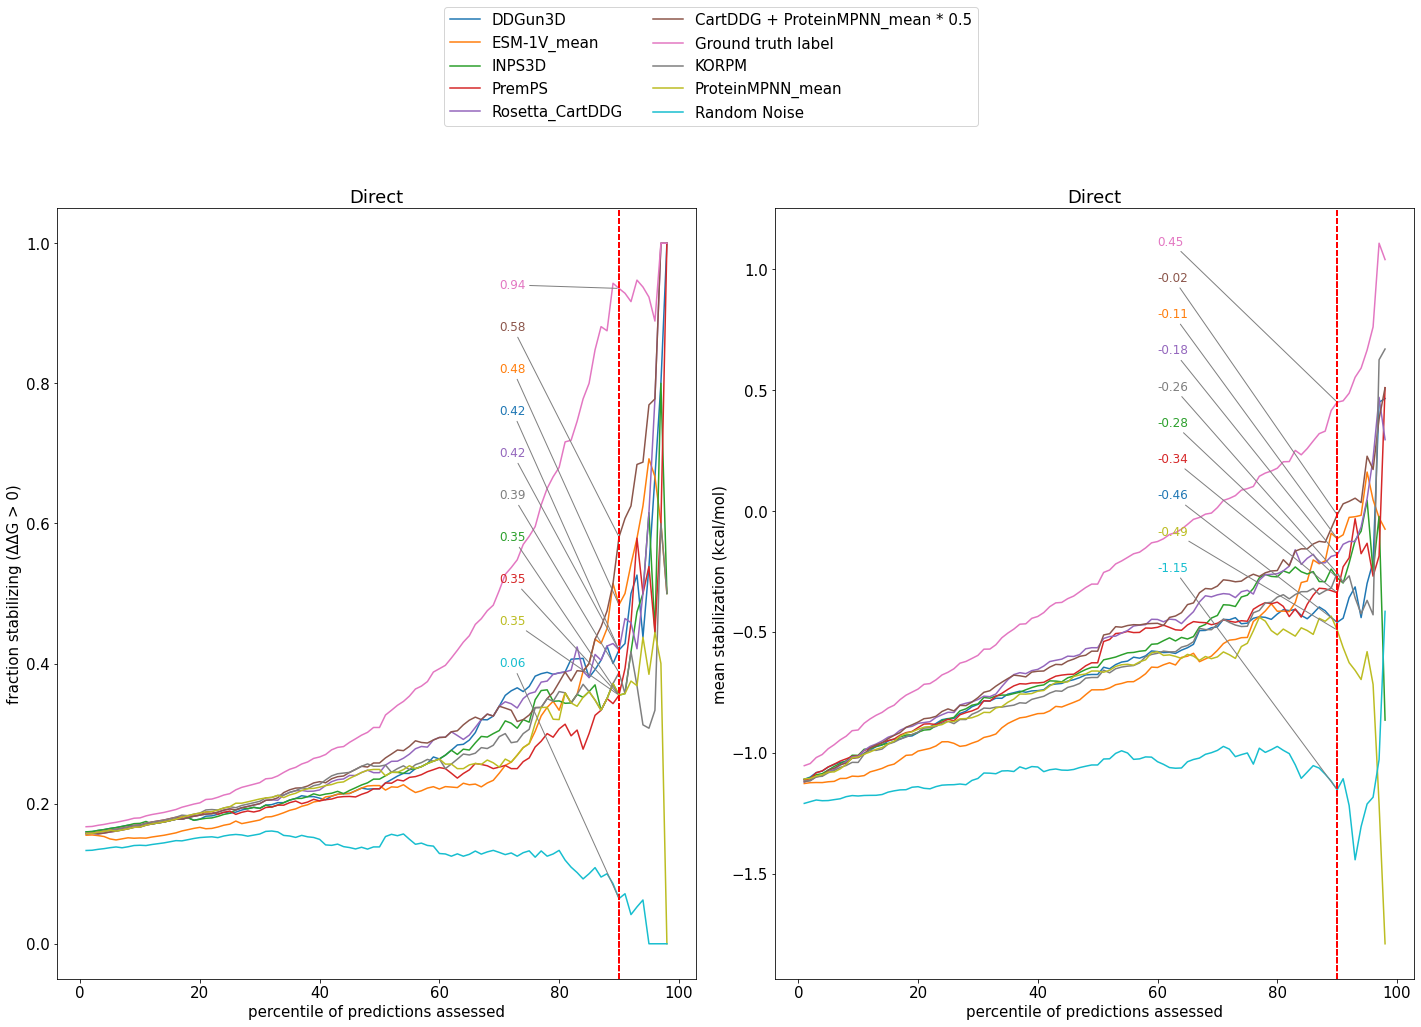

In [ ]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'esm1v_mean', 'PremPS', 'korpm', 'DDGun3D', 'INPS3D', 'ddG', 'random'], percentile_labels=[90], directions=['dir'])

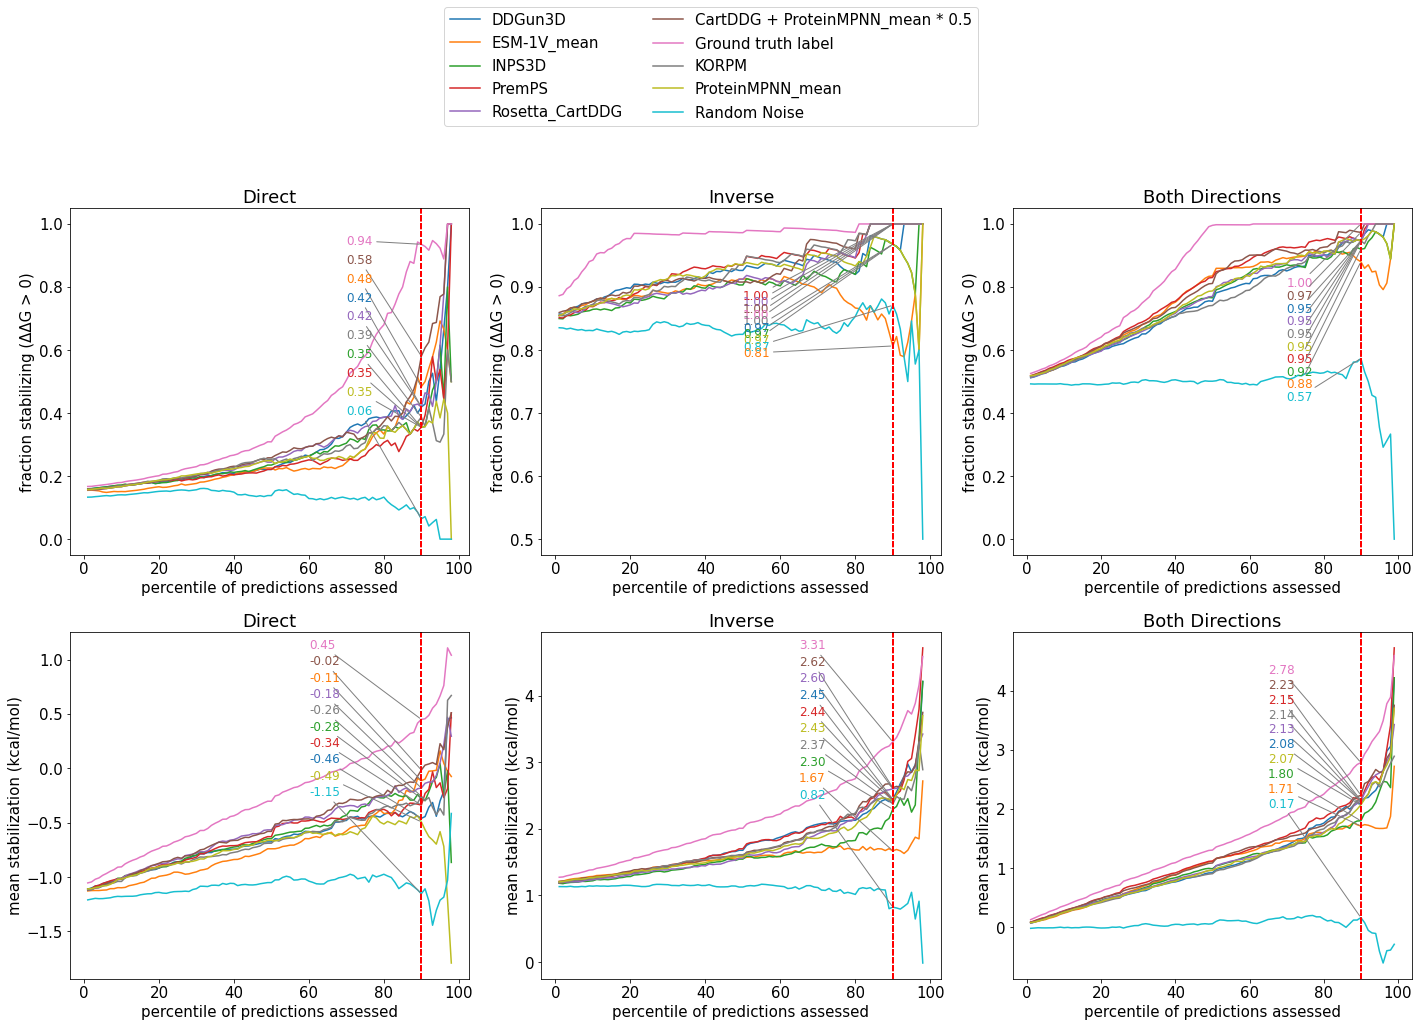

In [ ]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'esm1v_mean', 'PremPS', 'korpm', 'DDGun3D', 'INPS3D', 'ddG', 'random'], directions=['dir', 'inv'], percentile_labels=[90])

In [ ]:
pd.concat([dr.xs('dir').sort_values('90%', ascending=False).head(10)[['90%', '90$', 'net_stabilization']], dr.xs('dir').sort_values('90$', ascending=False).head(10).tail(9)[['90%', '90$', 'net_stabilization']]])

90%       90$  \
model_type model                                                     
structural ddG                                  0.935484  0.450097   
           mif + ACDC-NN-Seq * 0.5              0.612903  0.031226   
           I-Mutant3.0 + mifst * 1              0.612903  0.000226   
           mif + DDGun3D * 1                    0.612903 -0.030710   
           esm1v_mean + mif * 1                 0.612903  0.064968   
           esm1v_median + mif * 1               0.612903  0.094000   
           mifst + DDGun3D * 1                  0.612903 -0.025161   
           mifst + DDGun3D * 0.5                0.612903 -0.072161   
           mifst + SAAFEC-Seq * 1               0.612903  0.000226   
           mif + esm1v_median * 1               0.612903  0.094000   
           esmif_monomer + ACDC-NN-Seq * 0.5    0.580645  0.101323   
           mif + esm1v_median * 1               0.612903  0.094000   
           esm1v_median + mif * 1               0.612903  0.094000   
           korpm + msa_transformer_mean * 0.5   0.516129  0.088032   
           esmif_monomer + esm1v_median * 0.2   0.516129  0.083903   
           esmif_multimer + esm1v_median * 0.2  0.516129  0.080677   
           esmif_multimer + esm1v_mean * 0.2    0.516129  0.080677   
           esmif_monomer + esm1v_mean * 0.2     0.516129  0.080032   
           esmif_monomer + ACDC-NN * 0.5        0.516129  0.070032   

                                                net_stabilization  
model_type model                                                   
structural ddG                                             36.998  
           mif + ACDC-NN-Seq * 0.5                          2.560  
           I-Mutant3.0 + mifst * 1                          5.428  
           mif + DDGun3D * 1                                6.652  
           esm1v_mean + mif * 1                             8.598  
           esm1v_median + mif * 1                           6.618  
           mifst + DDGun3D * 1                              6.607  
           mifst + DDGun3D * 0.5                            6.606  
           mifst + SAAFEC-Seq * 1                           5.428  
           mif + esm1v_median * 1                           6.618  
           esmif_monomer + ACDC-NN-Seq * 0.5                0.783  
           mif + esm1v_median * 1                           6.618  
           esm1v_median + mif * 1                           6.618  
           korpm + msa_transformer_mean * 0.5              13.278  
           esmif_monomer + esm1v_median * 0.2               3.125  
           esmif_multimer + esm1v_median * 0.2              2.916  
           esmif_multimer + esm1v_mean * 0.2                2.216  
           esmif_monomer + esm1v_mean * 0.2                 1.266  
           esmif_monomer + ACDC-NN * 0.5                   -2.630